# Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/home_detection/code


In [2]:
from mobilkit.umni import *
from setup import P, Region, Dataset, HDA

In [3]:
import haversine as hs
import shutil

In [4]:
SP.start()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/06/04 06:41:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load data

## Algorithms

In [5]:
algos = [HDA(*x) for x in [
    ('A0', 'Centroid method', '#10ae01', '.'),
    ('A1', 'All-time clustering method', '#047cbd', 'v'),
    ('A2', 'Binned clustering method', '#4930c7', '^'),
    ('A3', 'Stay-point method', '#ff7e81', '*'),
    ('A4', 'Grid frequency method', '#c92ad5', 'd')
]]; sns.color_palette([x.color for x in algos])

[(0.06274509803921569, 0.6823529411764706, 0.00392156862745098),
 (0.01568627450980392, 0.48627450980392156, 0.7411764705882353),
 (0.28627450980392155, 0.18823529411764706, 0.7803921568627451),
 (1.0, 0.49411764705882355, 0.5058823529411764),
 (0.788235294117647, 0.16470588235294117, 0.8352941176470589)]

## Datasets and regions

In [6]:
regions = [Region.load(k) for k in P.params.get('regions').keys()]
br = regions[1]; br

Region(Baton Rouge)

In [7]:
datasets = [Dataset.load(k, [r for r in regions if r.key == v['region']][0])
            for k, v in P.params.get('datasets').items()]
ds2 = datasets[1]; ds2

Dataset D2(Baton Rouge: 2021-08-26 - 2021-09-07)

In [8]:
regions = list({ds.region for ds in datasets})

## Common users across all algos

In [9]:
def get_common_users(ds, algos=algos):
    return Seq(list(reduce(set.intersection, [
        set(pd.read_parquet(ds.data / f'homes/{alg}.parquet')[UID])
        for alg in algos])), name=UID)

In [10]:
for ds in tqdm(datasets):
    ds.common_users = get_common_users(ds)

  0%|          | 0/8 [00:00<?, ?it/s]

## Dataset summary

In [11]:
def table_dataset_summary(datasets=datasets):
    res = []
    for ds in tqdm(datasets):
        acs = gpd.read_file(ds.region.data / 'acs.gpkg')
        users = ds.common_users.reset_index()
        pct_popu = round(len(users) / acs['popu'].sum(), 3)
        df = SP.read_parquet(ds.data / 'counts.parquet')
        df = df.join(SP.pdf2sdf(users), on=UID)
        nPings = df.agg(F.sum('n_pings')).collect()[0][0]
        period = ds.start.strftime('%b %-d') + ' – ' + ds.end.strftime('%b %-d, %Y')
        res.append(dict(name=ds.key, region=ds.region.name,
                        period=period, nDays=len(ds.dates),
                        n_users=len(users) / 1000, pct_popu=pct_popu, 
                        n_pings=nPings / 1e6))
    return Pdf(res)

# %time table_dataset_summary() # t=1:28

# M1: Land use performance metric

## Load the buffers
Clip them within the city limit for comparison

In [12]:
def get_resi_buffers_clipped(rgn, max_buffer=200):
    paths = [f for f in (rgn.data / 'landuse/buffers_within_city_limit')
             .glob('*.parquet') if int(f.stem) <= max_buffer]
    return pd.concat([gpd.read_parquet(f) for f in paths])

# get_resi_buffers_clipped(br)

In [13]:
# t=0:07
pbar = tqdm(regions)
for rgn in pbar:
    pbar.set_description(str(rgn))
    rgn.resi = get_resi_buffers_clipped(rgn)

  0%|          | 0/4 [00:00<?, ?it/s]

## Compute performance

In [14]:
def get_resi_detection_rate(ds, alg, users=None, filt_commons=True,
                            save=True, overwrite=False, pbar=False, time=True):
    outfile = ds.data / f'metrics/{alg}/M1.parquet'
    if outfile.exists() and not overwrite:
        return pd.read_parquet(outfile)
    start_time = dt.datetime.now()
    boundary = gpd.read_file(ds.region.data / 'city_limit.gpkg')
    homes = pd.read_parquet(ds.data / f'homes/{alg}.parquet')
    if filt_commons:
        homes = homes.merge(ds.common_users, on=UID)
    if isinstance(users, Pdf):
        homes = homes.merge(users, on=UID)
    homes = mk.geo.pdf2gdf(homes, crs=CRS_DEG)
    homes = (homes.sjoin(boundary, predicate='within')
             .set_index(UID)[['geometry']])
    resi = ds.region.resi.set_index('buffer').sort_index()
    df = Pdf(0, columns=resi.index, index=homes.index)
    rows = zip(resi.index, resi.geometry)
    if pbar: rows = tqdm(list(rows))
    for buf, geom in rows:
        geom = Gdf({'geometry': [geom]}, crs=CRS_DEG)
        within = homes.sjoin(geom, predicate='within')
        df.loc[within.index, buf:] = 1
        homes = homes.loc[list(set(homes.index) - set(within.index))]
    df = df.astype(np.int8)
    df.columns = df.columns.astype(str)
    if save:
        df.to_parquet(U.mkfile(outfile))
    if time:
        print(f'Runtime for {ds} for {alg}: {dt.datetime.now() - start_time}')
    return df
    
# %time x = get_resi_detection_rate(ds2, 'A1', overwrite=1, save=0); x

In [15]:
%%time
# t=3:39 ({1=>0:09, 2=>0:06, 3=>0:16, 4=>0:36, 5=>0:28, 6=>0:47, 7=>0:18, 8=>0:59})
for ds in tqdm(datasets):
    for alg in algos:
        df = get_resi_detection_rate(ds, alg, overwrite=False)

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 855 ms, sys: 169 ms, total: 1.02 s
Wall time: 784 ms


## Plot CDF

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 15.3 s, sys: 6.16 s, total: 21.5 s
Wall time: 13.4 s


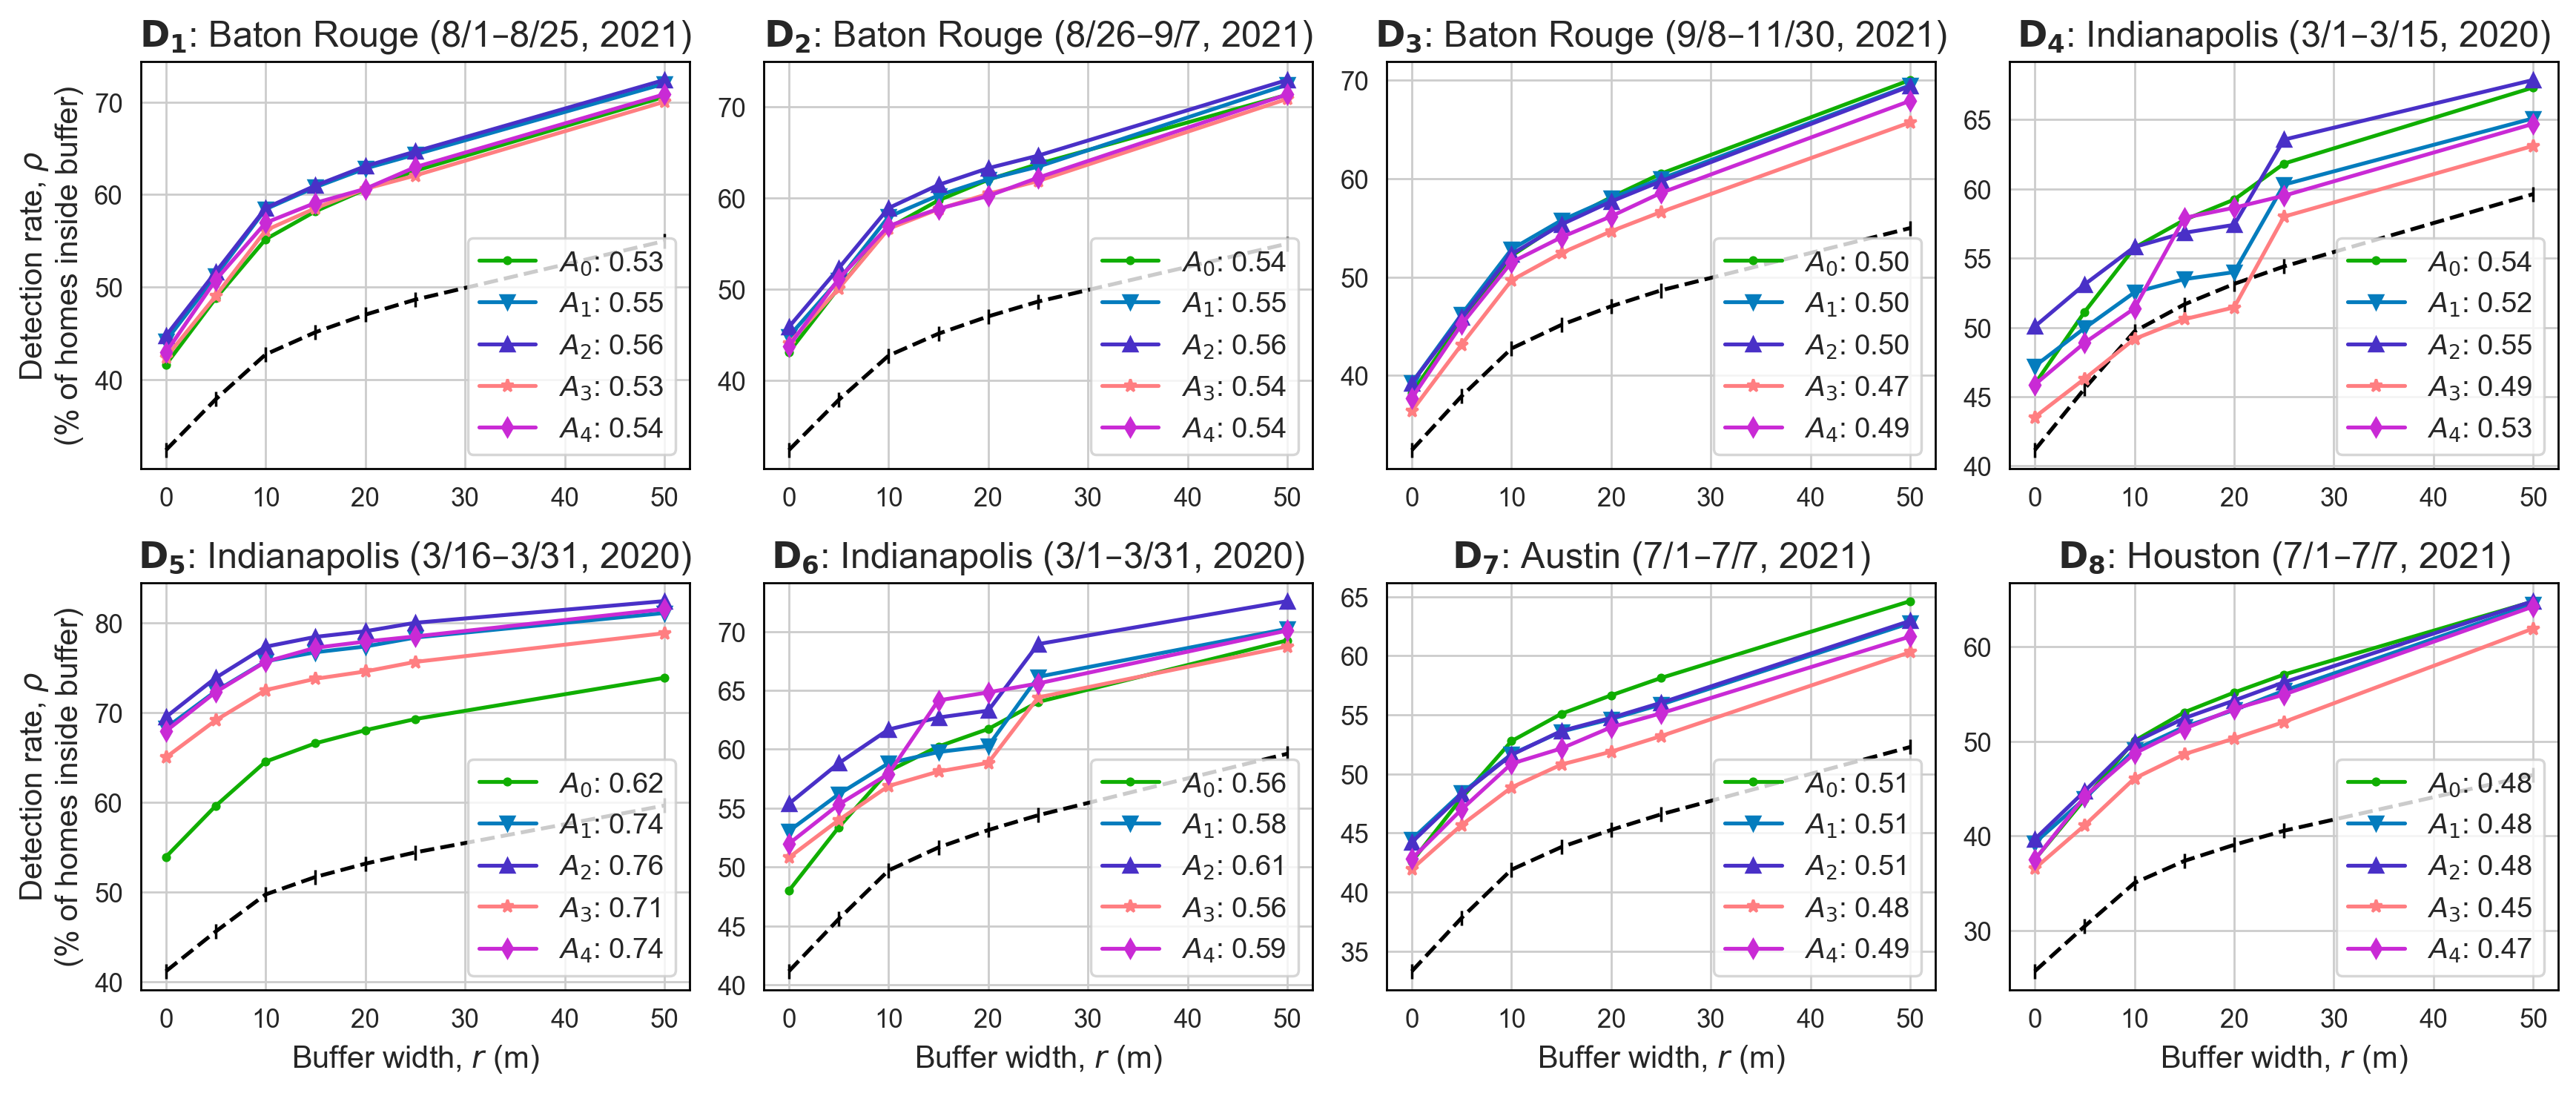

In [16]:
def fig_m1(datasets=datasets, algos=algos, ncol=4, size=(3.5, 3), dpi=100, max_buf=None):
    nrow = int(np.ceil(len(datasets)) / ncol)
    figsize = (ncol * size[0], nrow * size[1])
    _, axes = plt.subplots(nrow, ncol, figsize=figsize, dpi=dpi, sharey=False)
    for i, (ax, ds) in enumerate(tqdm(list(zip(axes.flatten(), datasets)))):
        city_lim = gpd.read_file(ds.region.data / 'city_limit.gpkg')
        tot_area = city_lim.to_crs(CRS_M).area.sum()
        resi = (ds.region.resi.query(f'buffer <= {max_buf}')
                .set_index('buffer').sort_index().to_crs(CRS_M))
        resi['pct_area'] = resi.area / tot_area * 100
        ax = U.plot(ax, framebordercolor='k')
        ax.plot(resi.index, resi['pct_area'], marker='|', color='k', ls='--', lw=1.5)
        for alg in algos:
            df = pd.read_parquet(ds.data / f'metrics/{alg}/M1.parquet')
            y = df.sum(axis=0) / len(df)
            y.index = y.index.astype(int)
            y = y[y.index <= max_buf]
            x = y.index.values
            m1 = (y * (x.max() - x)).sum() / (x.max() - x).sum()
            label = '%s: %0.2f' % (alg.math(), m1)
            ax.plot(x, y * 100, color=alg.color, label=label, lw=1.5, 
                    marker=alg.marker, markersize=5)
        title = '%s: %s (%s–%s)' % (
            ds.math(bold=True), ds.region.name, 
            ds.start.strftime('%-m/%-d'), ds.end.strftime('%-m/%-d, %Y'))
        xlab = r'Buffer width, $r$ (m)' if i // ncol == nrow - 1 else ''
        ylab = (r'Detection rate, $\rho$'+'\n(% of homes inside buffer)'
                if i % ncol == 0 else '')
        ax = U.plot(ax, title=title, xlab=xlab, ylab=ylab)
        ax.legend(loc='lower right')
    plt.tight_layout()
    
%time x = fig_m1(dpi=250, max_buf=50); x # t=0:18

# M2: Trajectory proximity

## Compute daily min distances

In [17]:
def dist_deg2m(dist, lat, a=6_371_001, b=6_356_752):
    """
    See `mobilkit.geo.dist_m2deg` for more details.
    """
    lat = np.deg2rad(lat)
    curve_radius = (a * b) ** 2 / (
        (a * np.cos(lat)) ** 2 + (b * np.sin(lat)) ** 2) ** 1.5
    return float(np.deg2rad(dist) * curve_radius)

In [18]:
def get_traj_proximity(ds, alg, save=True, overwrite=False):
    outfile = ds.data / f'metrics/{alg}/M2.parquet'
    if outfile.exists() and not overwrite:
        return SP.read_parquet(outfile)
    start_time = dt.datetime.now()
    homes = (pd.read_parquet(ds.data / f'homes/{alg}.parquet')
             .merge(ds.common_users, on=UID)
             .rename(columns={LON: 'homeX', LAT: 'homeY'}))
    df = SP.read_parquet(ds.data / f'night_pings')
    df = df.select(UID, F.arrays_zip(LON, LAT, TS).alias('pts'))
    df = df.select(UID, F.explode('pts').alias('pt'))
    df = df.select(UID, *[F.col('pt')[x].alias(x) for x in [LON, LAT, TS]])
    df = df.withColumn('day', F.floor(F.col(TS) / 86400).cast(T.int16))
    df = df.groupby(UID, 'day').agg(*[
        F.collect_list(x).alias(x) for x in [LON, LAT]])
    df = df.join(SP.pdf2sdf(homes), on=UID)
    df = df.withColumn('n_pings', F.size(LON).cast(T.int16))
    def dist4home(x, y, homex, homey):
        d = np.min(((Arr(x) - homex)**2 + (Arr(y) - homey)**2)**0.5)
        return dist_deg2m(d, homey)
    df = df.withColumn('dist', F.udf(dist4home, T.float)
                       (LON, LAT, 'homeX', 'homeY'))
    df = df.select(UID, 'day', 'n_pings', 'dist')
    if save:
        df.toPandas().to_parquet(U.mkfile(outfile))
    return df
    
# %time x = get_traj_proximity(ds2, 'A1', save=0, overwrite=1); x

In [19]:
%%time
# t=11:03 ({1=>1:01, 2=>0:20, 3=>???, 4=>???, 5=>???, 6=>???, 7=>???, 8=>???})
for ds in tqdm(datasets):
    df = get_traj_proximity(ds, alg, overwrite=False)

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 49.7 ms, sys: 6.83 ms, total: 56.5 ms
Wall time: 5.13 s


## Visualize

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 15 s, sys: 4.6 s, total: 19.6 s
Wall time: 13.4 s


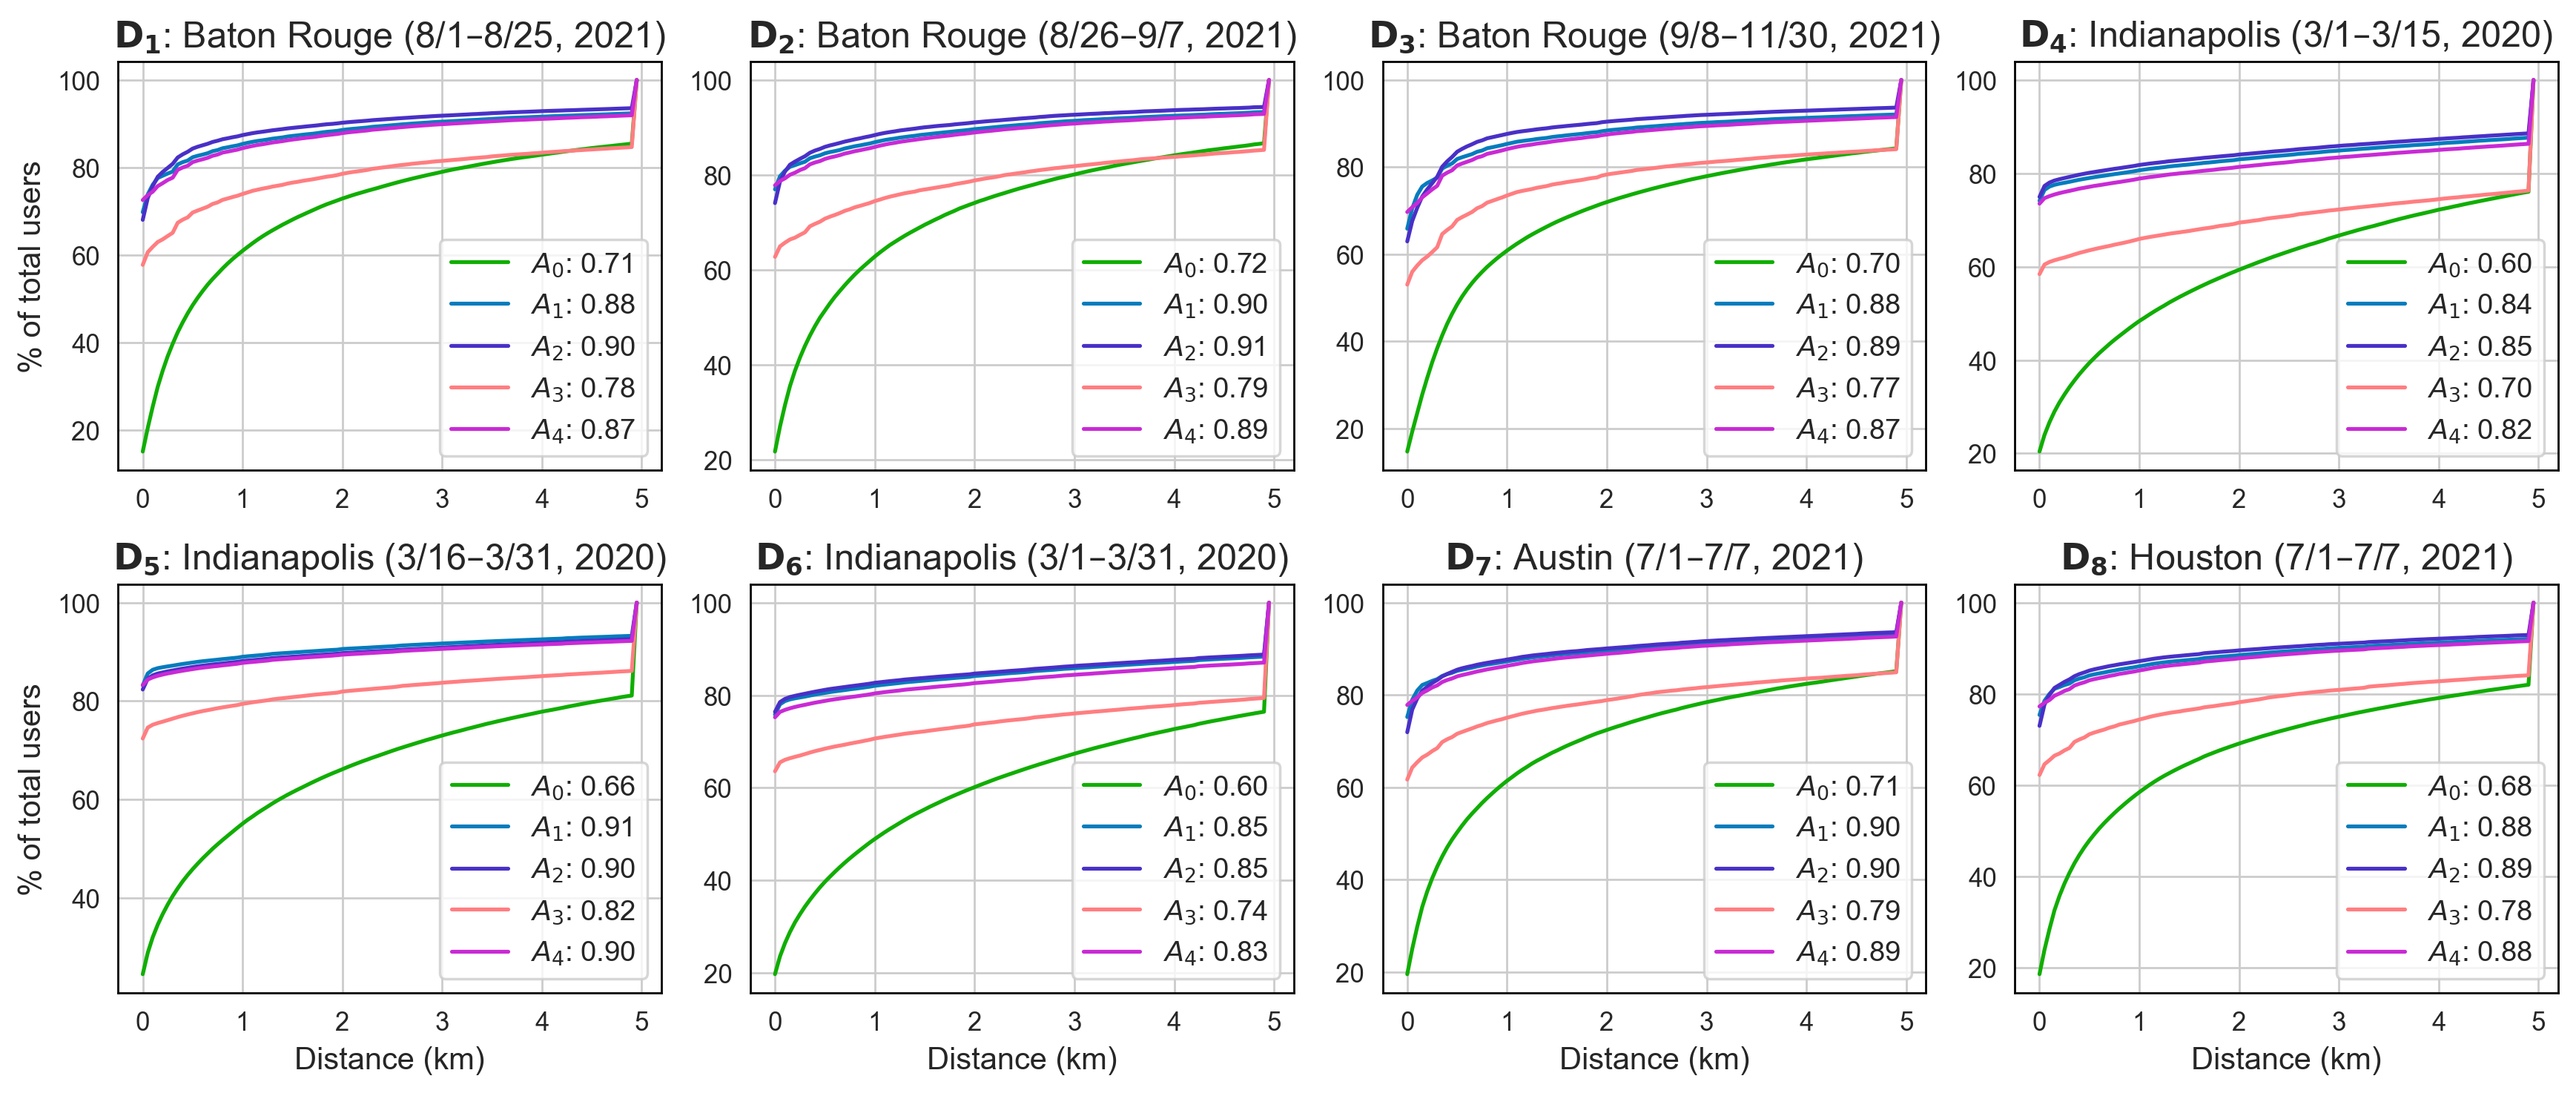

In [20]:
def fig_m2(datasets=datasets, algos=algos, ylog=False, ncol=4, vmax=5, 
           bins=100, cum=True, panel_size=(3.5, 3), dpi=120):
    nrow = int(np.ceil(len(datasets)) / ncol)
    figsize = (ncol * panel_size[0], nrow * panel_size[1])
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, dpi=dpi, sharey=False)
    for i, (ax, ds) in enumerate(tqdm(list(zip(axes.flatten(), datasets)))):
        ax = U.plot(ax, framebordercolor='k')
        for alg in algos:
            df = pd.read_parquet(ds.data / f'metrics/{alg}/M2.parquet')
            for j, (agg_fn, ls) in enumerate([(np.median, '-')]):
                df2 = df.groupby(UID)['dist'].agg(agg_fn)
                y, x = np.histogram((df2.values / 1000).clip(0, vmax), bins=bins)
                y = (y.cumsum() if cum else y) / y.sum() * 100
                m2 = y.sum() / (100 * len(y))
                ax.plot(x[:-1], y, color=alg.color, ls=ls,
                        label='%s: %0.2f' % (alg.math(), m2) if j == 0 else None)
        title = '%s: %s (%s–%s)' % (
            ds.math(bold=True), ds.region.name, 
            ds.start.strftime('%-m/%-d'), ds.end.strftime('%-m/%-d, %Y'))
        xlab = 'Distance (km)' if i // ncol == nrow - 1 else ''
        ylab = '% of total users' if i % ncol == 0 else ''
        ax = U.plot(ax, title=title, xlab=xlab, ylab=ylab, ylog=ylog)
        ax.legend()
    plt.tight_layout()

%time x = fig_m2(dpi=250); x # t=0:13

# M3: Home stay duration

Originally prepared in [/home/umni2/a/umnilab/users/mittal53/home inference/data files/final_results](/home/umni2/a/umnilab/users/mittal53/home%20inference/data%20files/final_results) and then copied to `{ds.data}/metrics/{alg}/M3.parquet`.

## Plot CDF

  0%|          | 0/8 [00:00<?, ?it/s]

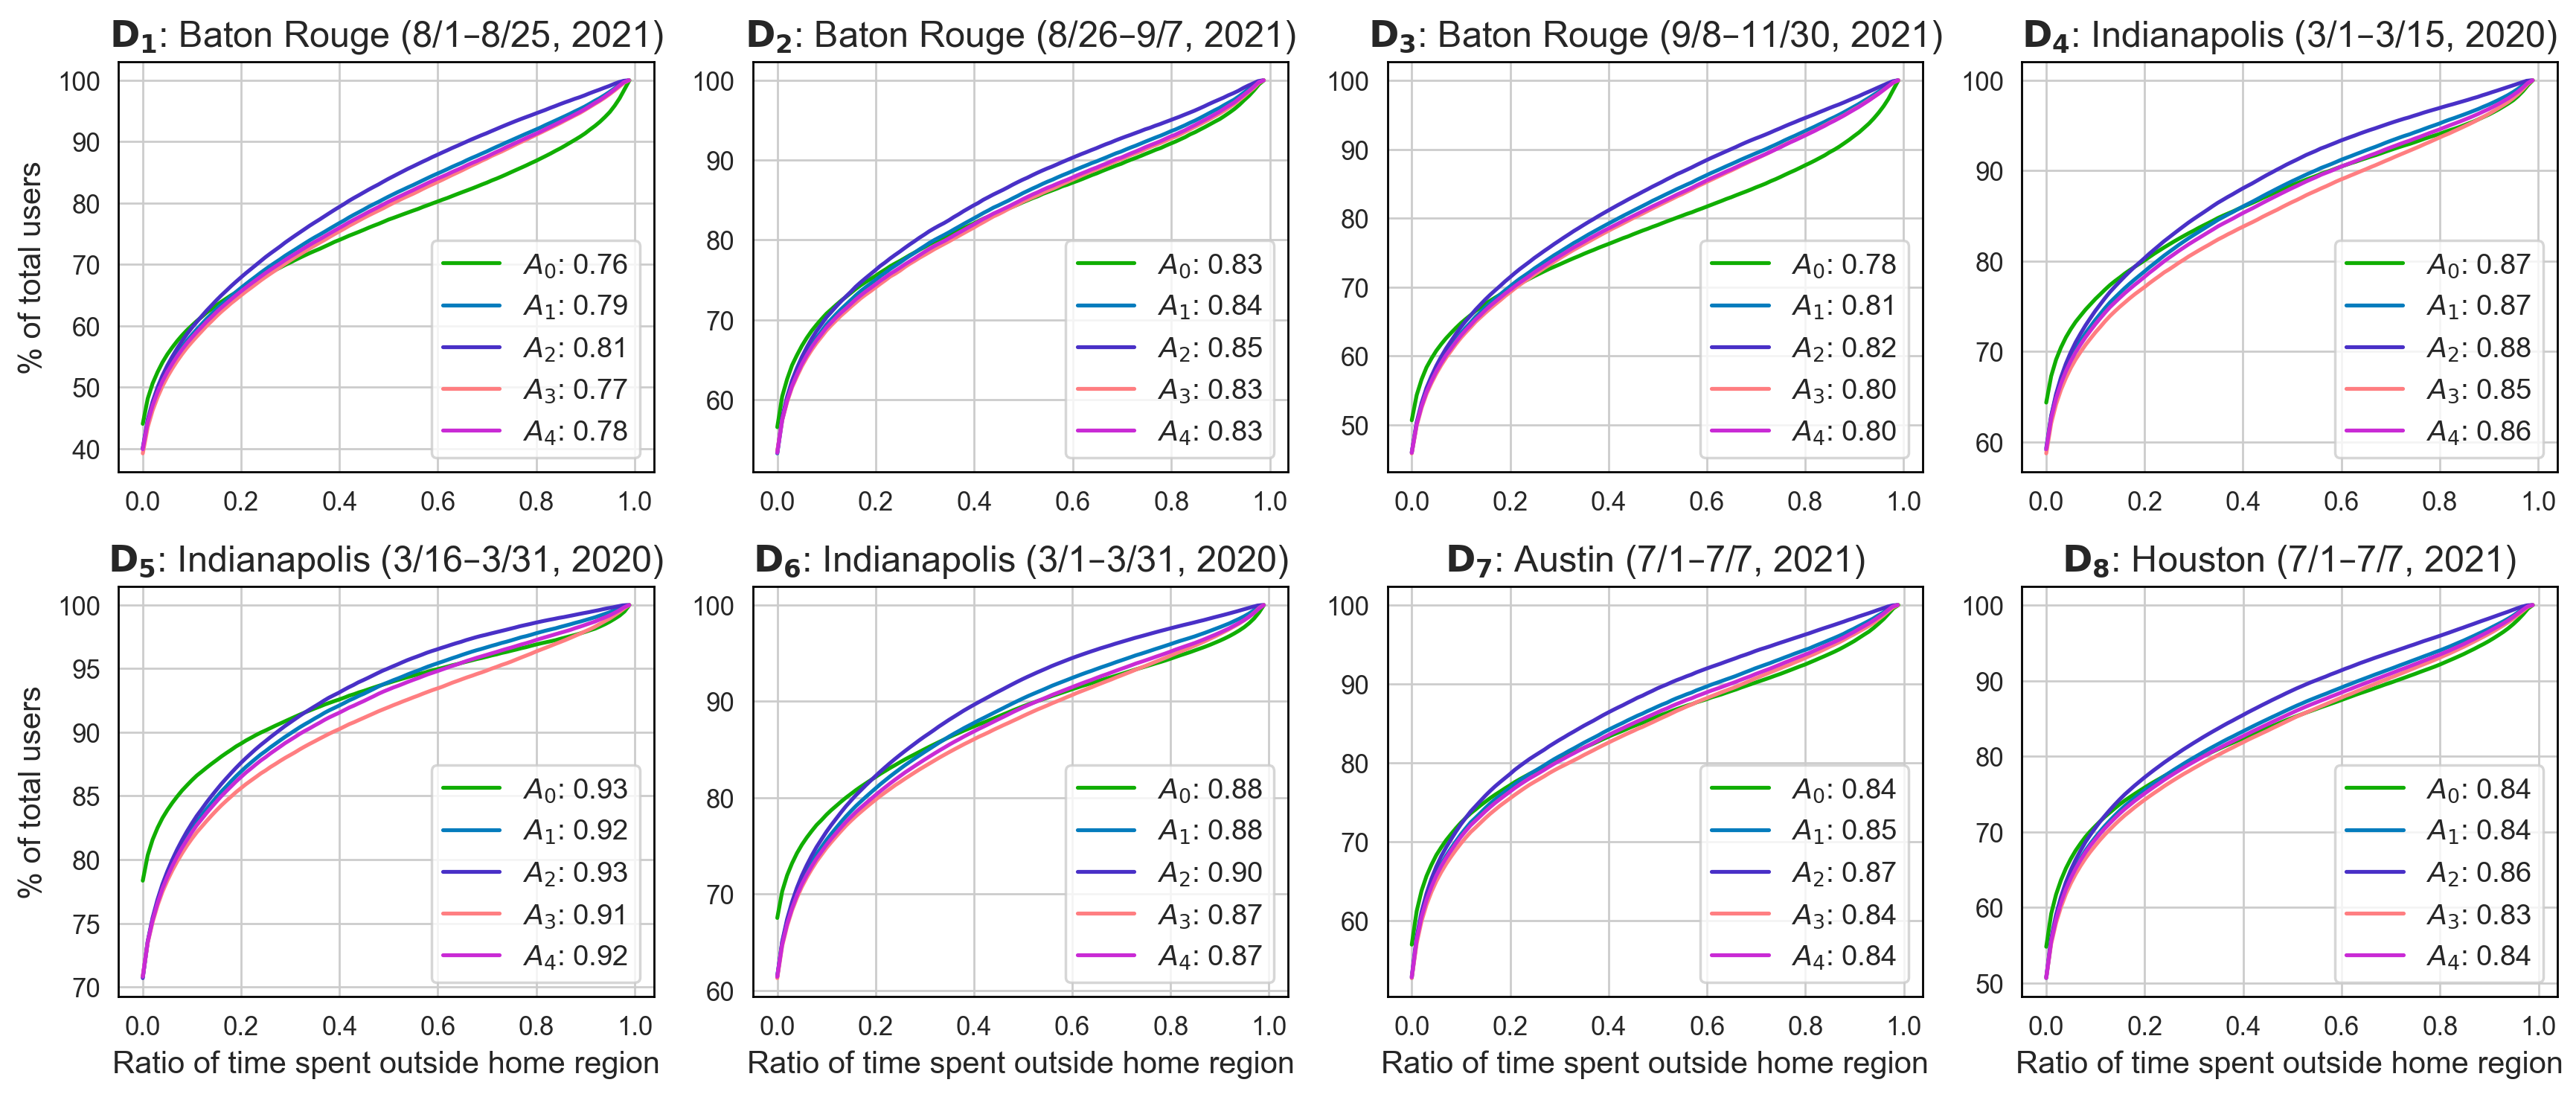

In [21]:
def fig_m3(datasets=datasets, algos=algos, ylog=False,
           ncol=4, bins=100, panel_size=(3.5, 3), dpi=120):
    nrow = int(np.ceil(len(datasets)) / ncol)
    figsize = (ncol * panel_size[0], nrow * panel_size[1])
    _, axes = plt.subplots(nrow, ncol, figsize=figsize, dpi=dpi, sharey=False)
    for i, (ax, ds) in enumerate(tqdm(list(zip(axes.flatten(), datasets)))):
        ax = U.plot(ax, framebordercolor='k')
        for alg in algos:
            df = pd.read_parquet(ds.data / f'metrics/{alg}/M3.parquet')
            df = df.merge(ds.common_users, on=UID)
            df['home_stay_ratio'] = 1 - df['home_time_spent'] / df['total_time_spent']
            y, x = np.histogram(df['home_stay_ratio'], bins=bins); x = x[:-1]
            y = y.cumsum() / y.sum()
            m3 = y.mean()
            label = '%s: %0.2f' % (alg.math(), m3)
            ax.plot(x, y * 100, color=alg.color, label=label)
        title = '%s: %s (%s–%s)' % (
            ds.math(bold=True), ds.region.name, 
            ds.start.strftime('%-m/%-d'), ds.end.strftime('%-m/%-d, %Y'))
        xlab = 'Ratio of time spent outside home region' if i // ncol == nrow - 1 else ''
        ylab = '% of total users' if i % ncol == 0 else ''
        ax = U.plot(ax, title=title, xlab=xlab, ylab=ylab, ylog=ylog)
        ax.legend()
    plt.tight_layout()

fig_m3(dpi=250)

## Overall figure

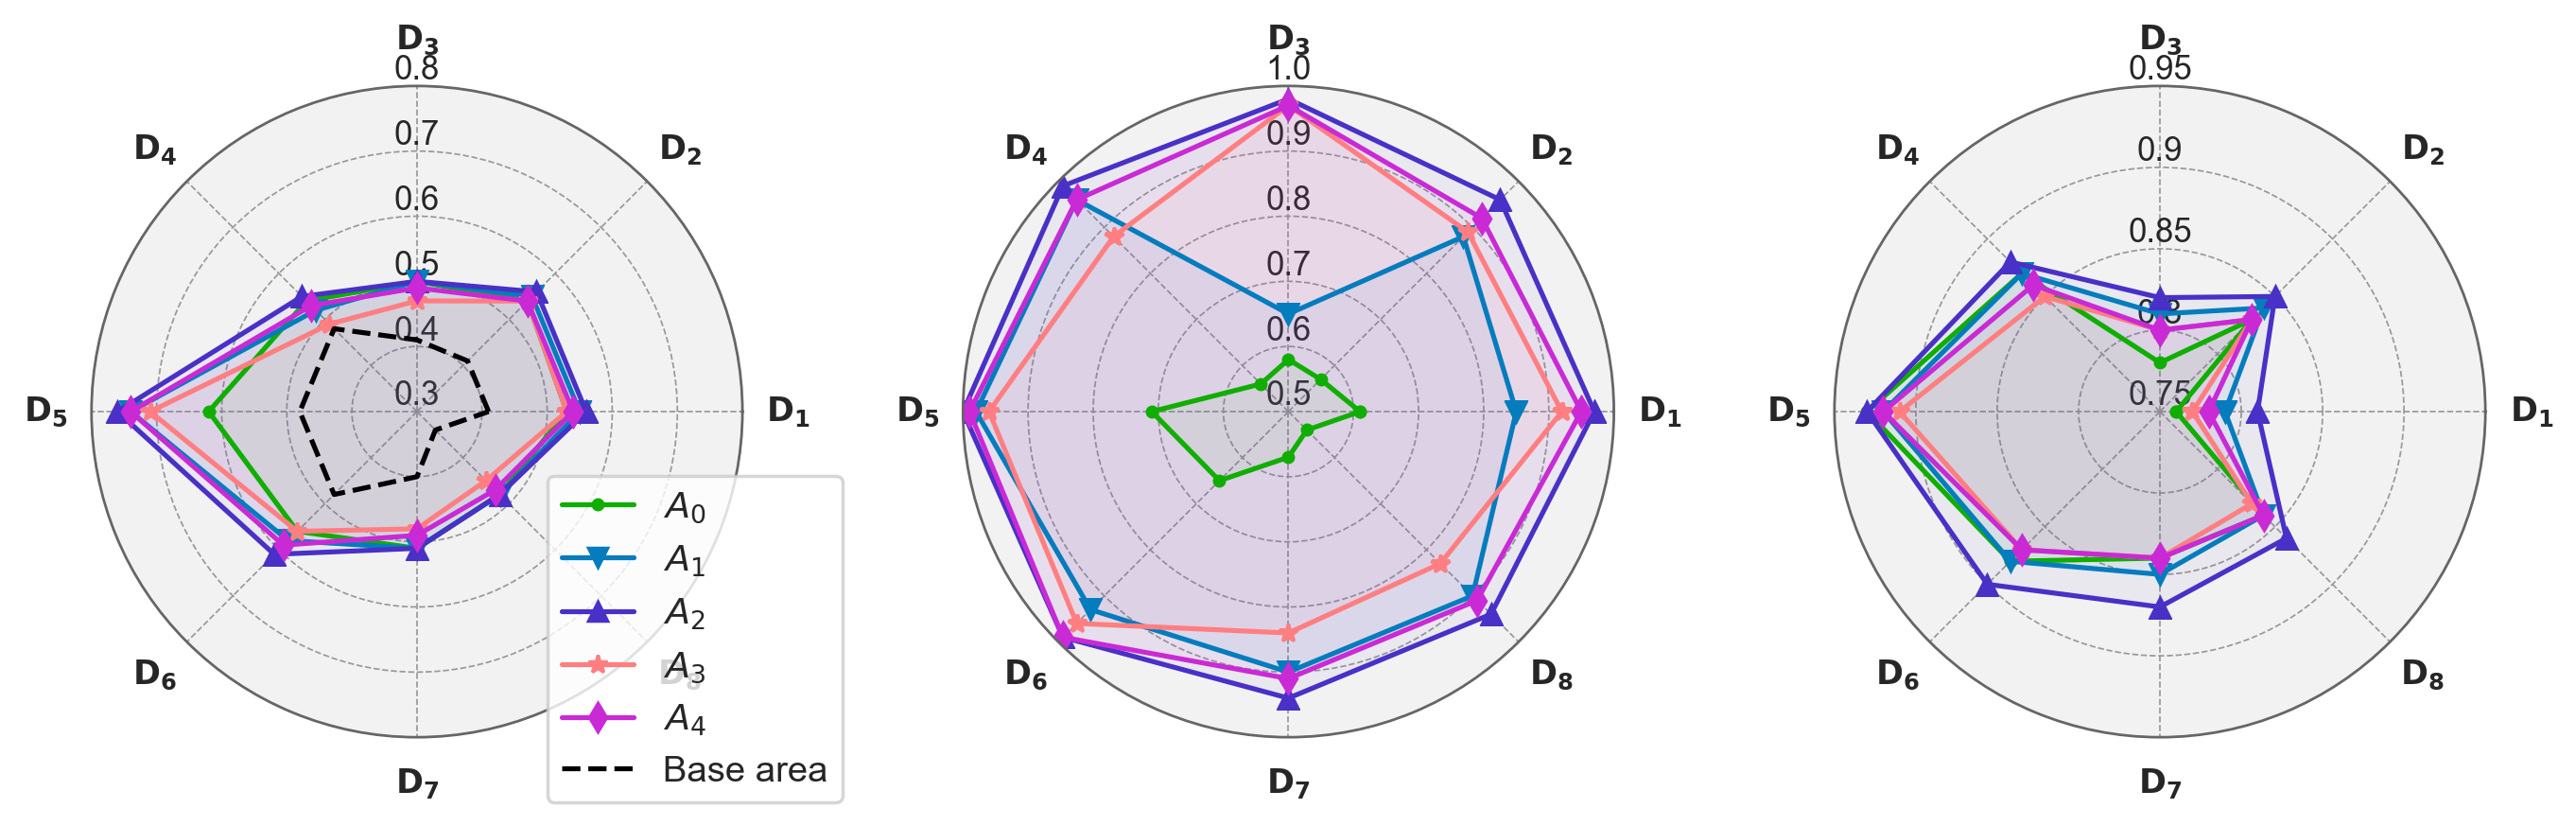

In [22]:
def fig_performance(datasets=datasets, algos=algos, step=0.1, dpi=100):
    data = pd.read_csv(P.data / '_etc/Paper-Tables.csv')
    _, axes = plt.subplots(1, 3, figsize=(11, 3.5), dpi=dpi, 
                           subplot_kw={'projection': 'polar'})
    sns.set_style('whitegrid')
    shutup.please()
    for i, (m, df) in enumerate(data.groupby('Metric')):
        df = df.drop(columns='Metric').set_index('Dataset')
        rmin, rmax = df.min().min(), df.max().max()
        x = np.arange(0, 1 + 0.01, step)
        rmin = np.round(x[x <= rmin][-1], 1)
        rmax = np.round(x[x >= rmax][0], 1)
        if m == 'M3':
            rmin, rmax, step = 0.75, 0.95, 0.05
        rticks = np.round(np.arange(rmin, rmax + 0.01, step), 2)
        ax = U.plot(axes[i], ylim=(rmin, rmax))
        ax.set_yticklabels(rticks)
        angles = [n / len(df) * 2 * np.pi for n in range(len(df))]
        angles += angles[:1]
        for alg in algos:
            r = df[alg.key].tolist()
            r += r[:1]
            ax.plot(angles, r, color=alg.color, marker=alg.marker, label=alg.math())
            ax.fill(angles, r, color=alg.color, alpha=0.05)
        if m == 'M1':
            r = df['Base area'].tolist()
            r += r[:1]
            ax.plot(angles, r, ls='--', color='k', label='Base area')
            ax.legend(loc=(0.7, -0.1))
        
        ax.set_xticks(angles[:-1], [ds.math(bold=True) for ds in datasets])
        ax.set_yticks(rticks, rticks, ha='center')
        ax.set_rlabel_position(90)
        ax.grid(ls='--', color='#999', lw=0.5)
        ax.set_facecolor('grey')
        ax.patch.set_alpha(0.1)
        ax.spines['polar'].set_color('#666')
    shutup.jk()
    plt.tight_layout()

fig_performance(dpi=250)

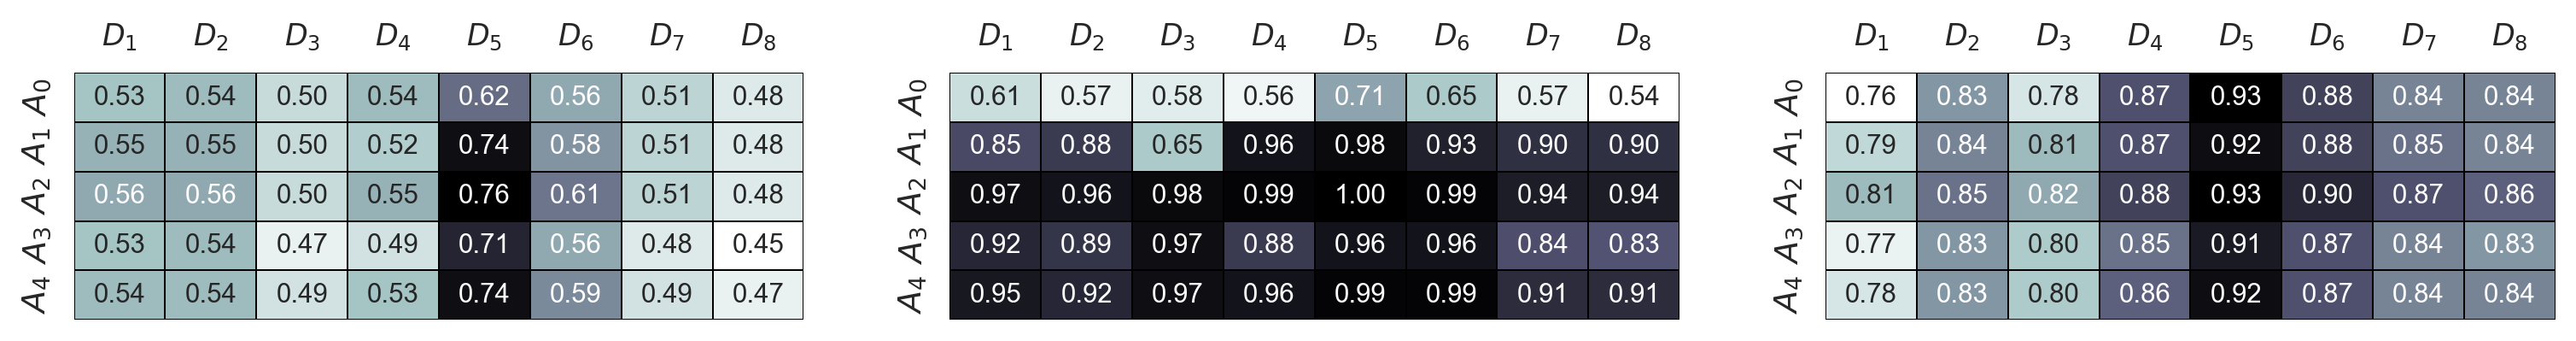

In [23]:
def fig_metrics_table(datasets=datasets, algos=algos, cmap='bone_r', size=(15, 1.5), dpi=250):
    data = pd.read_csv(P.data / '_etc/Paper-Tables.csv').drop(columns='Base area')
    _, axes = plt.subplots(1, 3, figsize=size, dpi=dpi)
    for (metric, df), ax in zip(data.groupby('Metric'), axes):
        df = df.drop(columns='Metric').set_index('Dataset').T
        vmin, vmax = df.min().min(), df.max().max()
        sns.heatmap(data=df, ax=ax, fmt='.2f', cmap=cmap, 
                    annot=True, annot_kws=dict(fontsize=9), cbar=False,
                    norm=plt.Normalize(vmin, vmax), linecolor='k', linewidth=0.1)
        ax.set_yticklabels([f'${x[0]}_{x[1]}$' for x in df.index], fontsize=11)
        ax.set_xticklabels([f'${x[0]}_{x[1]}$' for x in df.columns], fontsize=10)
        ax.tick_params(labelbottom=False,labeltop=True)
        ax.set_xlabel('')

fig_metrics_table()

# Sensitivity analysis

In [24]:
day_hrs = P.params.get('filters.base_day_hours')
slot_size = P.params.get('filters.slot_size')
day_hrs, slot_size

([7, 19], 1800)

## Sorted users by quality

In [25]:
def get_user_ping_count(ds, day_hrs=day_hrs, slot_size=slot_size):
    df = SP.read_parquet(ds.data / 'counts.parquet')
    night_end, night_start = [x * 3600 / slot_size for x in day_hrs]
    df = df.where((df.slot >= night_start) | (df.slot <= night_end))
    df = df.groupby(UID).agg(
        F.count(UID).alias('total_slots'),
        F.sum('n_pings').alias('total_pings'),
        F.countDistinct('day_id').alias('n_nights'))
    df = df.withColumn('avg_pings', F.col('total_pings') / F.col('n_nights'))
    df = df.select(UID, 'total_pings', 'avg_pings', 'total_slots')
    df = df.toPandas()
    return df

# get_user_ping_count(ds2)

In [26]:
%time for ds in tqdm(datasets): ds.counts = get_user_ping_count(ds) # t=0:28

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 308 ms, sys: 310 ms, total: 618 ms
Wall time: 43.9 s


## Get metric sensitivity

In [27]:
def get_user_quality_bin(users, key, bins, is_quantile=False):
    assert UID in users.columns and key in users.columns
    kw = dict(include_lowest=True, right=False)
    if is_quantile:
        df = users.sort_values(key, ascending=False).reset_index(drop=True)
        vmin, vmax = min(bins), max(bins)
        cats = pd.cut(vmin + (vmax - vmin) * (df.index / len(df)), bins, **kw)
        df['binx'] = cats.rename_categories(cats.categories.right)
    else:
        cats = pd.cut(users[key], list(bins) + [np.inf], **kw)
        df = users.assign(binx=cats)
        df['binx'] = cats.cat.rename_categories(cats.cat.categories.left)
    return df.drop(columns=key)

In [58]:
# %%time
# t=1:33
def get_metric_sensitivity(metric, bin_key='total_pings', datasets=datasets,
                           algos=algos, bins=np.arange(0, 101, 10), is_quantile=False, cum=False,
                           hist_bins=100, kwargs=None, save=True, overwrite=False, progress=True):
    if progress: pbar = tqdm(total=len(datasets) * len(algos), desc=f'{metric}: {bin_key}')
    for i, ds in enumerate(datasets):
        all_users = ds.counts[[UID, bin_key]]
        for j, alg in enumerate(algos):
            if progress: pbar.update()
            res = []
            if progress: pbar.set_description(f'{ds.key} -> {alg}')
            label = f'{bin_key}_cumulative' if cum else bin_key
            outfile = ds.data / f'sensitivity/{label}/{alg}/{metric}.parquet'
            if outfile.exists() and not overwrite:
                continue
            df = pd.read_parquet(ds.data / f'metrics/{alg}/{metric}.parquet')
            if metric == 'M1':
                df = df.reset_index().melt(UID).astype({'buffer': int})
                df = df[df['buffer'] <= kwargs['max_buffer']]
                df = df.pivot(index=UID, columns='buffer', values='value')
                wt = (df.columns.max() - df.columns).values
                df = df.multiply(wt) / wt.sum()
                df = df.sum(axis=1).rename('yval').reset_index()
            elif metric == 'M2':
                df = (df.groupby(UID).agg({'dist': np.median})['dist']
                      .rename('yval').clip(0, kwargs['max_dist']).reset_index())
            elif metric == 'M3':
                df = df.assign(yval=1 - df['home_time_spent'] / df['total_time_spent'])
                df = df[[UID, 'yval']]
            users = df[[UID]].drop_duplicates().merge(all_users, on=UID)
            users = get_user_quality_bin(users, bin_key, bins, is_quantile=is_quantile)
            df = df.merge(users, on=UID)
            for binx in df['binx'].unique():
                df2 = df[df['binx'] >= binx] if cum else df[df['binx'] == binx]
                if metric == 'M1':
                    yval = df2['yval'].mean()
                elif metric in ['M2', 'M3']:
                    if len(df2) == 0: continue
                    y, _ = np.histogram(df2['yval'], hist_bins)
                    yval = (y.cumsum() / y.sum()).mean()
                res.append(dict(binx=binx, yval=yval))
            res = Pdf(res).dropna()
            if save:
                res.to_parquet(U.mkfile(outfile))

for metric, kw in [('M1', dict(max_buffer=50)), ('M2', dict(max_dist=5000)), ('M3', {})]:
    for key, is_quantile in [('total_pings', True), ('avg_pings', False)]:
        for cum in [True, False]:
            get_metric_sensitivity(metric, key, is_quantile=is_quantile, cum=cum,
                                   kwargs=kw, overwrite=0, save=1, progress=0)
# x = get_metric_sensitivity('M1', overwrite=1, save=0, kwargs=dict(max_buffer=50)); x

## Plot

### By total pings

CPU times: user 8.17 s, sys: 545 ms, total: 8.71 s
Wall time: 8.24 s


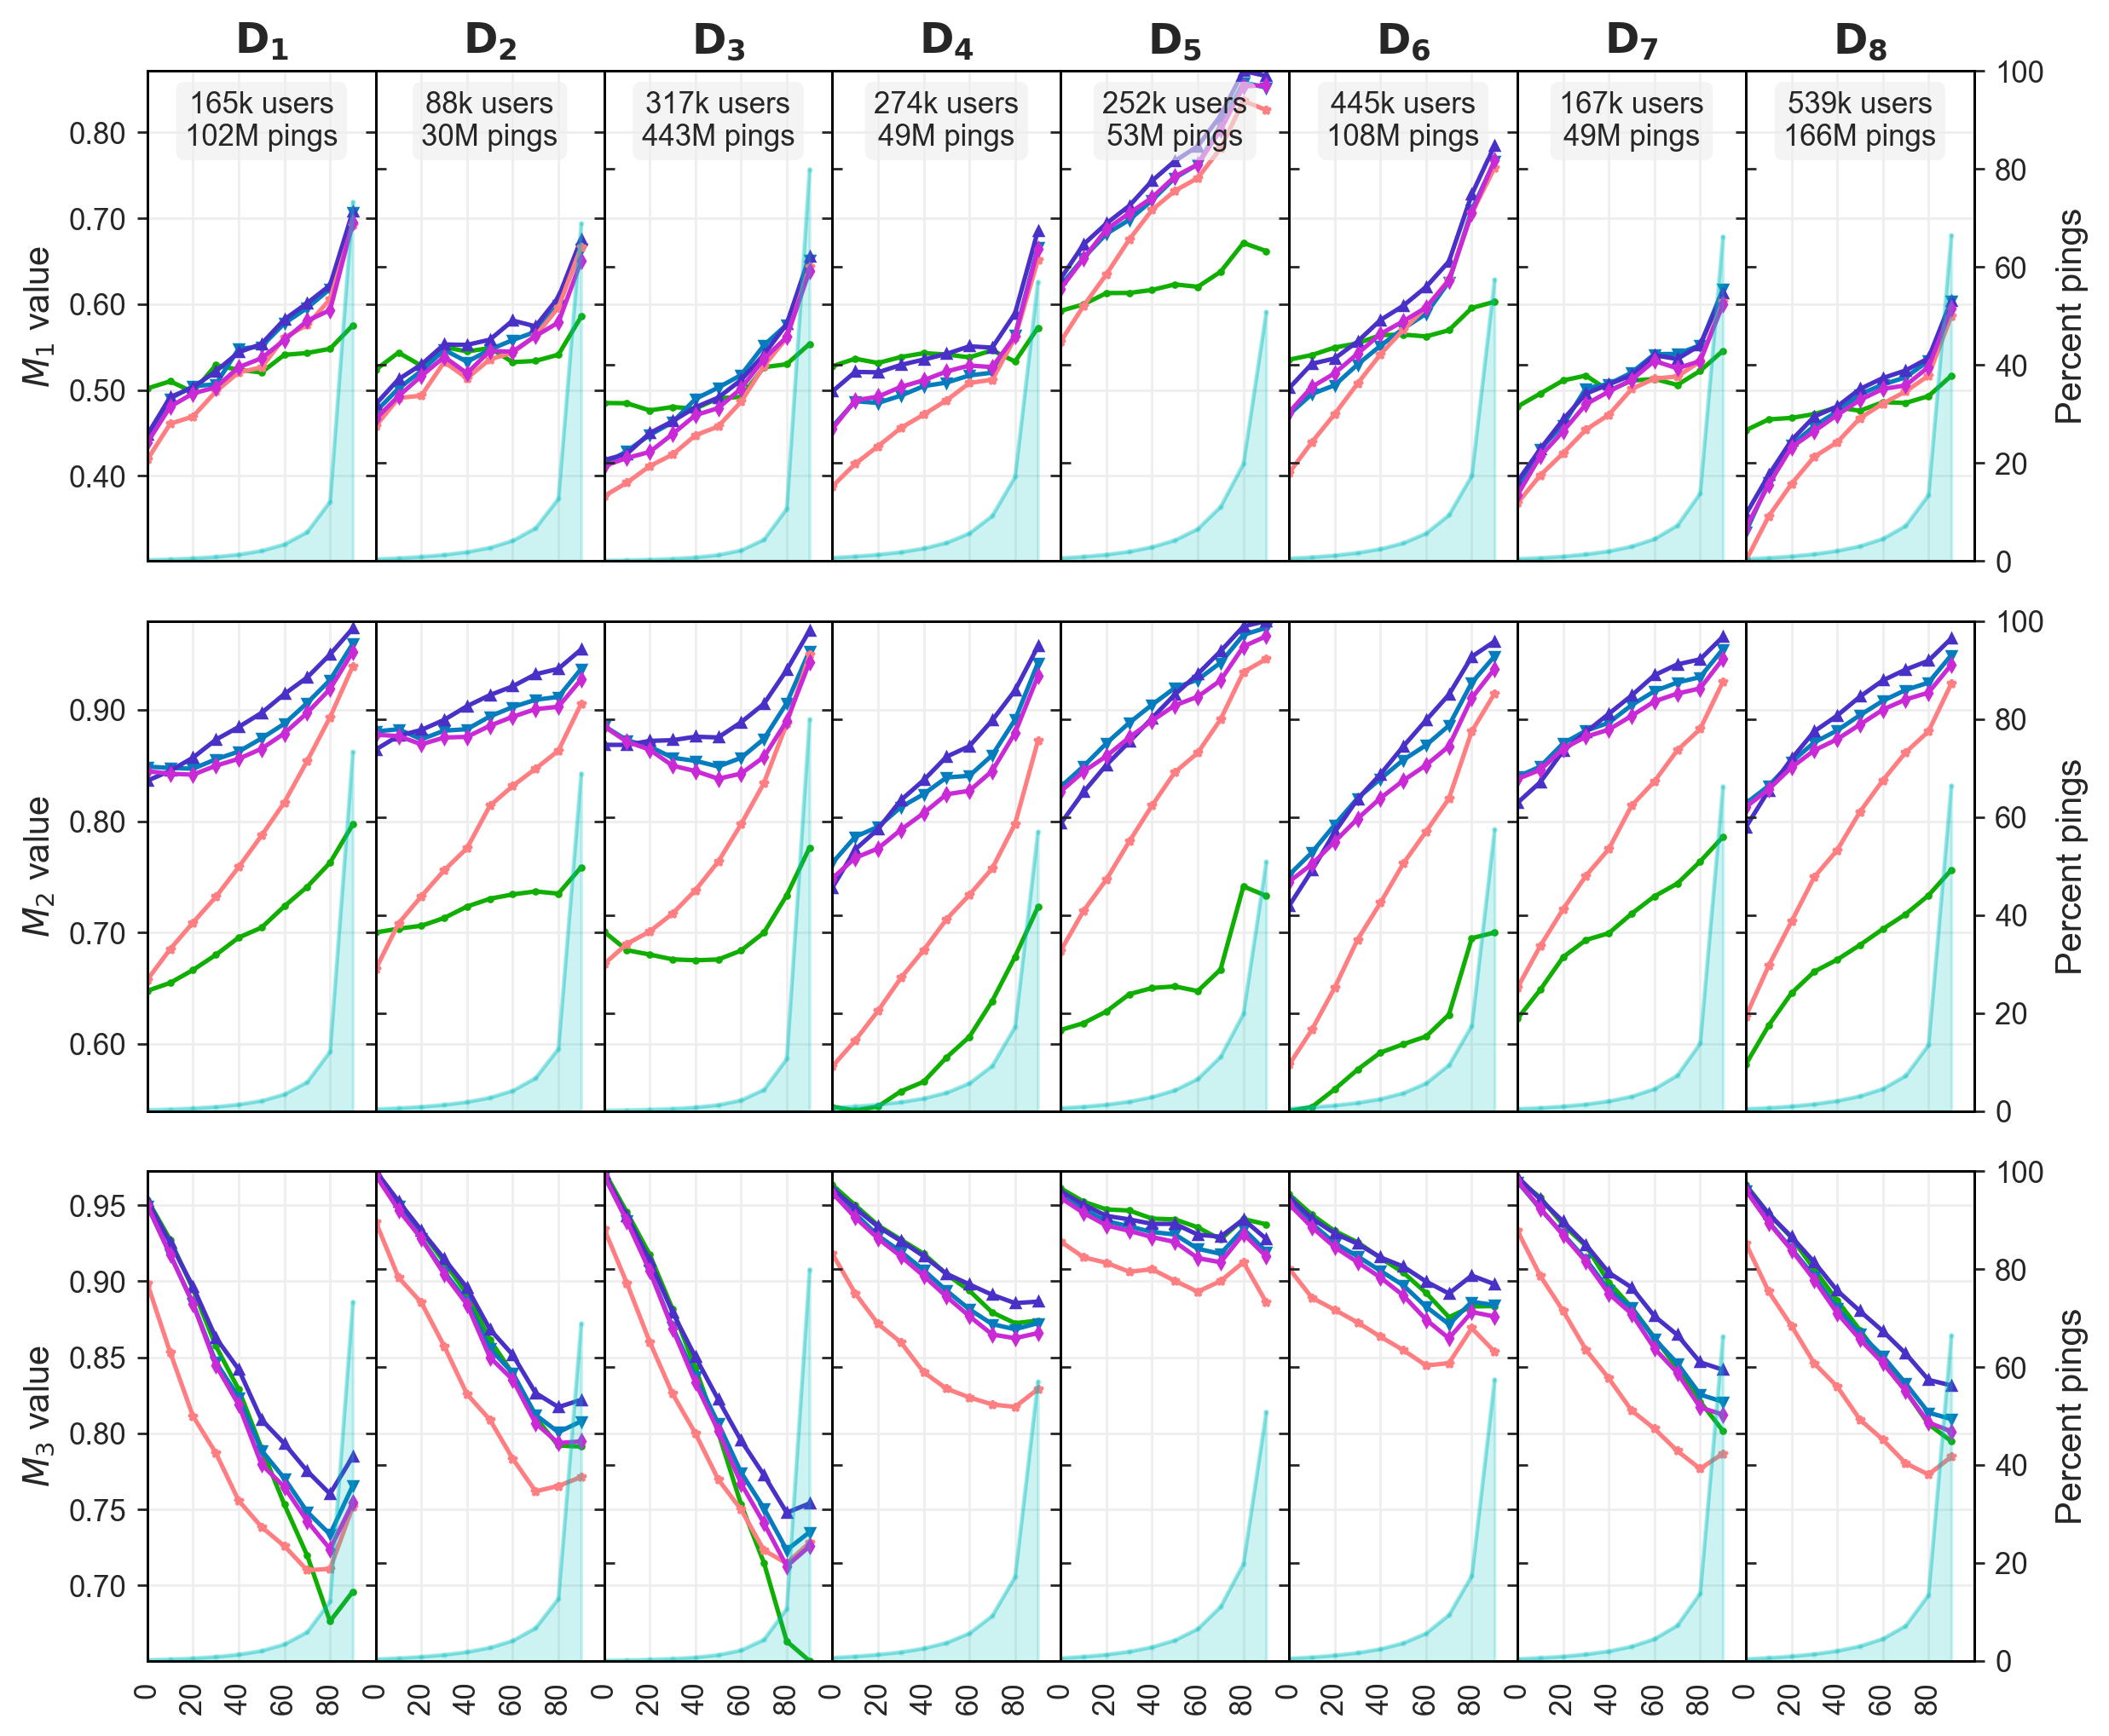

In [29]:
def plot_sensitivity_total(metrics=('M1', 'M2', 'M3'), datasets=datasets,
                           algos=algos, nbin=10, bg_color='c', bg_alpha=0.2,
                           size=(1.25, 2.75), dpi=120):
    nrow, ncol = len(metrics), len(datasets)
    _, axes = plt.subplots(nrow, ncol, dpi=dpi,
                           figsize=(ncol * size[0], nrow * size[1]))
    for i, metric in enumerate(metrics):
        ymin, ymax = [], []
        for j, ds in enumerate(datasets):
            ax = U.plot(axes[i, j], xlim=(0, 100), framebordercolor='k', 
                        xlab='', gridcolor='#eee')
            users = ds.counts.merge(ds.common_users, on=UID)
            nUsers, nPings = len(users), users['total_pings'].sum()
            for alg in algos:
                root = ds.data / 'sensitivity/total_pings'
                df = pd.read_parquet(f'{root}/{alg}/{metric}.parquet')
                y = df.set_index('binx')['yval'].pipe(lambda x: x[x != 0])
                y.index = (100 - y.index).rename('')
                ymin.append(y.min())
                ymax.append(y.max())
                y.plot(ax=ax, color=alg.color, marker=alg.marker, markersize=3)
            if i == 0: ax.set_title(ds.math(bold=1), fontsize=14)
            formatter = mpl.ticker.StrMethodFormatter('{x:,.2f}')
            ax.set_ylabel(f'${metric[0]}_{metric[1]}$ value' if j == 0 else '')
            ax.yaxis.set_major_formatter(formatter)
            if j != 0: ax.set_yticklabels([])
            if i == 0:
                label = f'{nUsers/1e3:.0f}k users\n{nPings/1e6:.0f}M pings'
                ax.text(0.5, 0.96, label, va='top', ha='center', transform=ax.transAxes,
                        bbox=dict(boxstyle='Round', pad=0.3, edgecolor='none',
                                  facecolor='#eee', alpha=0.6))
            y = users.sort_values('total_pings').reset_index(drop=True)
            y['binx'] = pd.cut(range(len(users)), len(df)).codes
            y = y.groupby('binx')['total_pings'].sum()
            y = pd.concat([y, df['binx']], axis=1).set_index('binx')['total_pings']
            y = y / y.sum() * 100
            y.index -= y.index.min()
            twin = U.plot(ax.twinx(), framebordercolor='k', ylim=(0, 100))
            y.plot(ax=twin, color=bg_color, marker='.',
                   markersize=2, lw=1, alpha=bg_alpha)
            y.plot(ax=twin, kind='area', color=bg_color, alpha=bg_alpha)
            twin.set_xticklabels([])
            twin.grid(False)
            twin.set_ylabel('Percent pings' if j == ncol - 1 else '')
            if j != ncol - 1: twin.set_yticklabels([])
            xticks = np.arange(0, 100 + 1, 20)
            ax.set_xticks(xticks[:-1], xticks[:-1], rotation=90)
            if i != nrow - 1: ax.set_xticklabels([])
        ymin, ymax = min(ymin), max(ymax)
        for j, ds in enumerate(datasets):
            axes[i, j].set_ylim(ymin, ymax)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0)
    
%time plot_sensitivity_total(dpi=250) # t=0:08

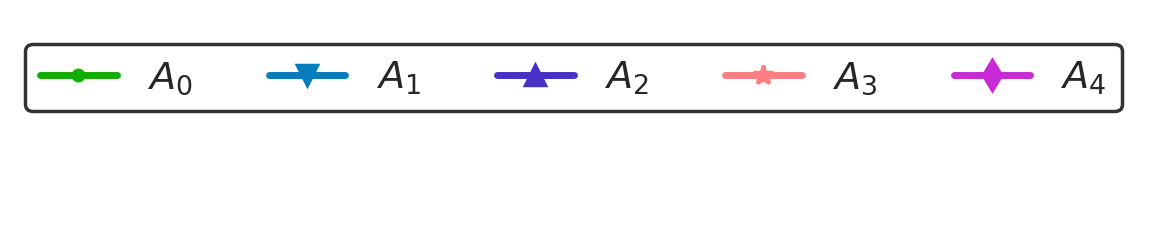

In [30]:
ax = U.plot(size=(1, 1), dpi=250)
ax.legend(handles=[
    mpl.lines.Line2D([0], [0], lw=2, color=alg.color, marker=alg.marker, label=alg.math())
    for alg in algos], ncol=len(algos), edgecolor='k')
ax.axis('off');

### By avg nightly pings

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 3.48 s, sys: 289 ms, total: 3.77 s
Wall time: 3.22 s


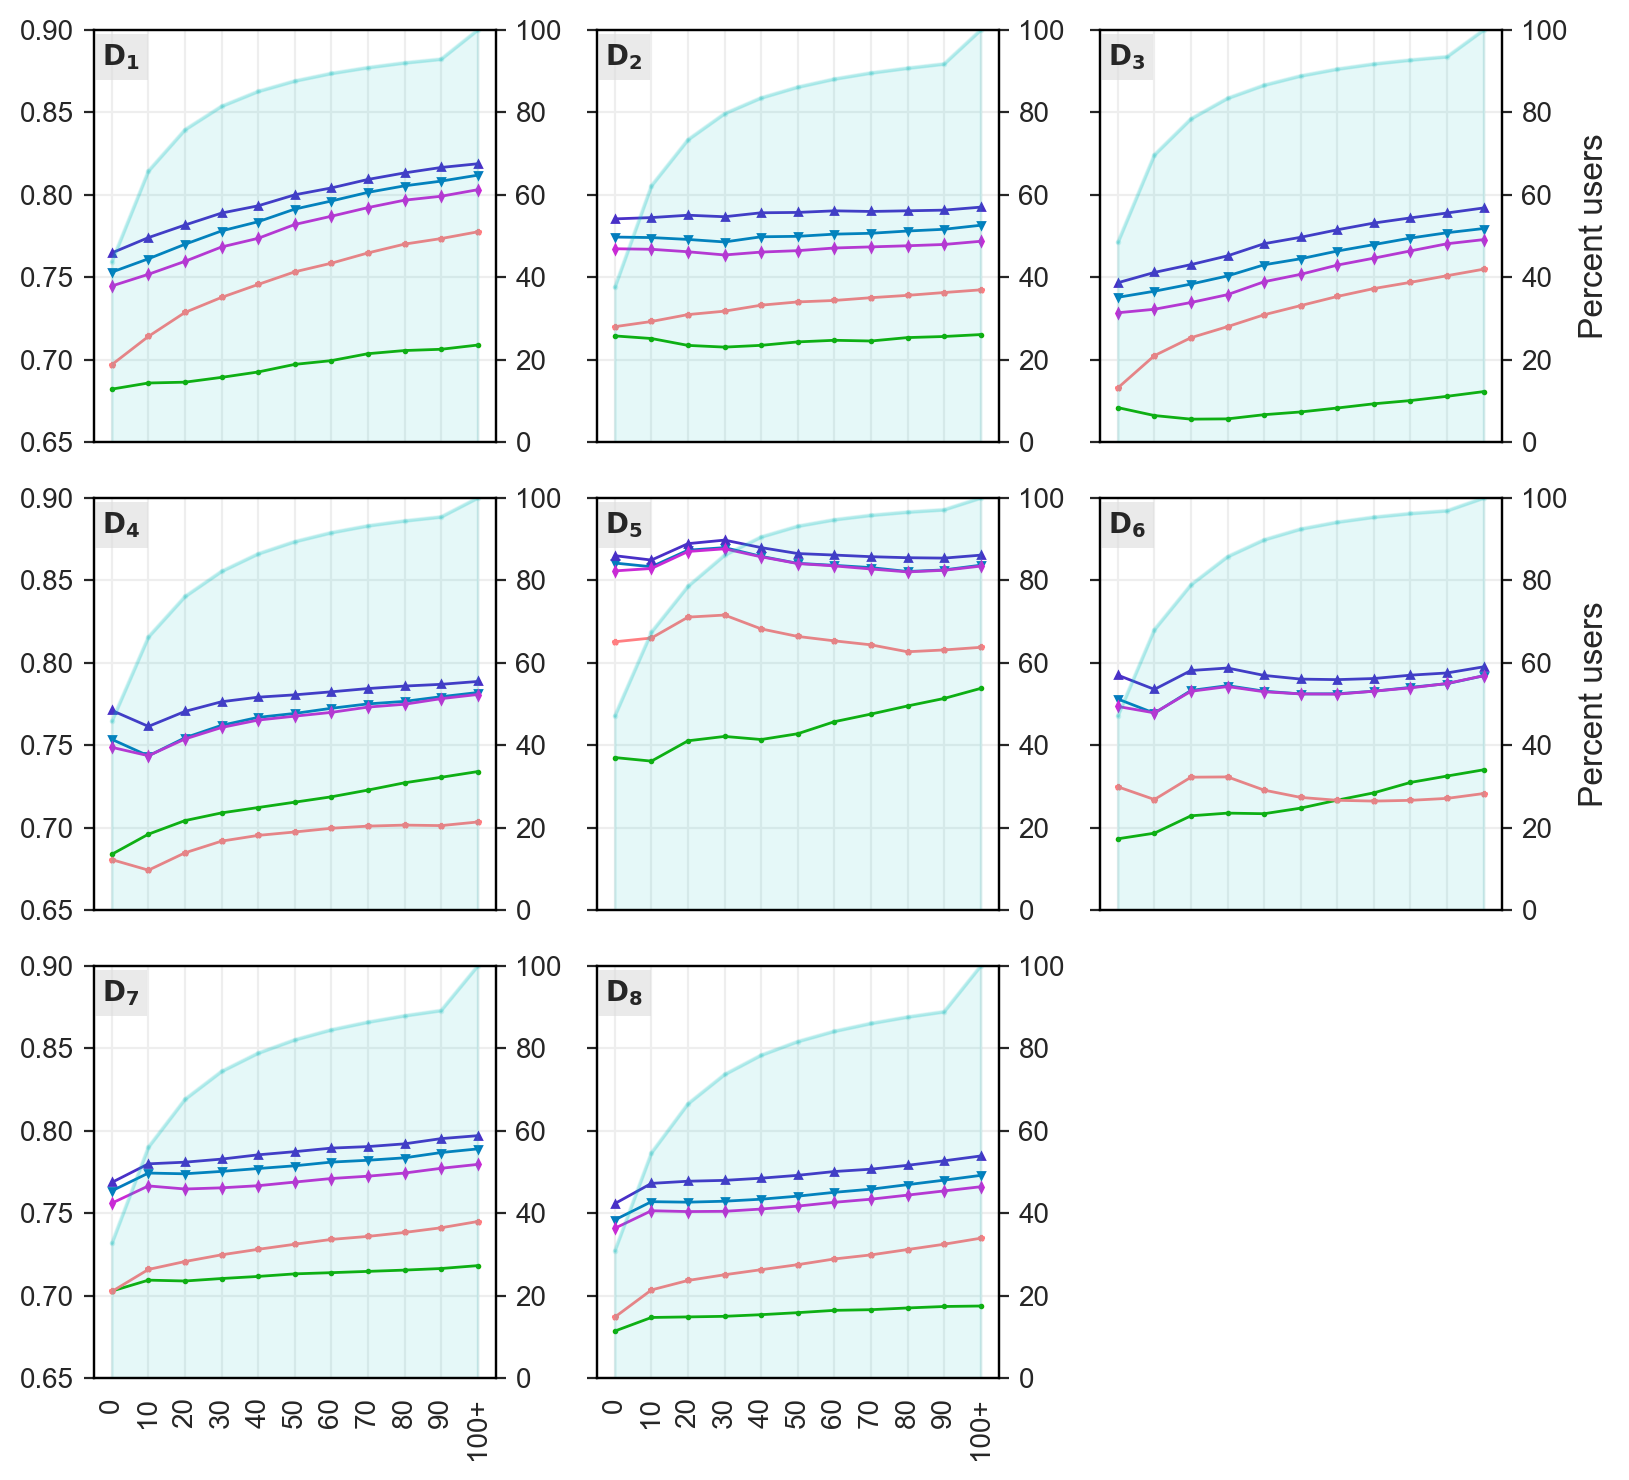

In [156]:
def plot_sensitivity_avg_pings(metrics=('M1', 'M2', 'M3'), datasets=datasets, algos=algos,
                               ncol=3, size=(3, 2), dpi=120, cum=True, area_plot=False):
    nrow = int(np.ceil(len(datasets) / ncol))
    _, axes = plt.subplots(nrow, ncol, dpi=dpi, sharey=True,
                           figsize=(ncol * size[0], nrow * size[1]))
    ymin, ymax = 1, 0
    for idx, ds in enumerate(tqdm(datasets)):
        i, j = idx // ncol, idx % ncol
        ax = U.plot(axes[i, j], framebordercolor='k', gridcolor='#eee')
        root = ds.data / 'sensitivity/avg_pings_cumulative'
        for alg in algos:
            df = pd.concat([
                pd.read_parquet(f'{root}/{alg}/{metric}.parquet')
                .set_index('binx')['yval'].rename(metric)
                for metric in metrics], axis=1).sort_index()
            y = (df['M1'] + df['M2'] + (df['M3'])) / 3
            y.index = y.index.astype(int)
            ymin = min(ymin, y.min())
            ymax = max(ymax, y.max())
            y.plot(ax=ax, color=alg.color, marker=alg.marker, markersize=2, lw=1)
        if j != 0: ax.set_yticklabels([])
        usr = ds.counts.merge(ds.common_users, on=UID)
        ax.text(0.02, 0.97, ds.math(bold=1), va='top', ha='left', 
                transform=ax.transAxes, bbox=dict(
            boxstyle='Square', pad=0.3, edgecolor='none', facecolor='#ddd', alpha=0.6))
        bins = y.index.tolist() + [np.inf]
        usr['binx'] = pd.cut(usr['avg_pings'], bins, labels=y.index.tolist(), 
                             include_lowest=True, right=False)
        usr = usr.groupby('binx').size().rename('n_users')
        usr = usr / usr.sum() * 100
        if cum: usr = usr.cumsum()
        twin = ax.twinx()
        twin = U.plot(twin, framebordercolor='k', ylim=(0, 100))
        if area_plot:
            df = usr.reset_index().astype({'binx': float})
            df.plot.line(x='binx', y='n_users', ax=twin, color='c', 
                         marker='.', markersize=2, lw=1, alpha=0.15, legend=None)
            df.plot.area(x='binx', y='n_users', ax=twin, color='c', alpha=0.1, legend=None)
        else:
            twin.plot(usr, color='k', marker='.', markersize=2, lw=1, ls='--')
        twin.grid(False)
        ax.set_xlabel('')
        ax.set_ylabel('')
        xticks = [str(x) for x in y.index[:-1]] + [f'{y.index[-1]}+']
        ax.set_xticks(y.index, xticks, rotation=90)
        if i != nrow - 1: ax.set_xticklabels([])
        twin.set_xlabel('')
        twin.set_ylabel('Percent users' if j == ncol - 1 else '')
        if i != nrow - 1: twin.set_xticklabels([])
        if j != 0: ax.set_yticklabels([])
        formatter = mpl.ticker.StrMethodFormatter('{x:,.2f}')
        ax.yaxis.set_major_formatter(formatter)
    ymin = np.floor(ymin * 20) / 20
    ymax = np.ceil(ymax * 20) / 20
    yticks = np.round(np.arange(ymin, ymax + 0.04, 0.05), 2)
    for i, ax in enumerate(axes.flatten()):
        ax.set_ylim(ymin, ymax)
        ax.set_yticks(yticks, [f'{x:.2f}' for x in yticks])
        if i >= len(datasets):
            ax.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25)
    
%time x = plot_sensitivity_avg_pings(dpi=200, size=(2.75, 2.5), ncol=3, area_plot=1); x

In [32]:
# plot_sensitivity_avg_pings(dpi=200)

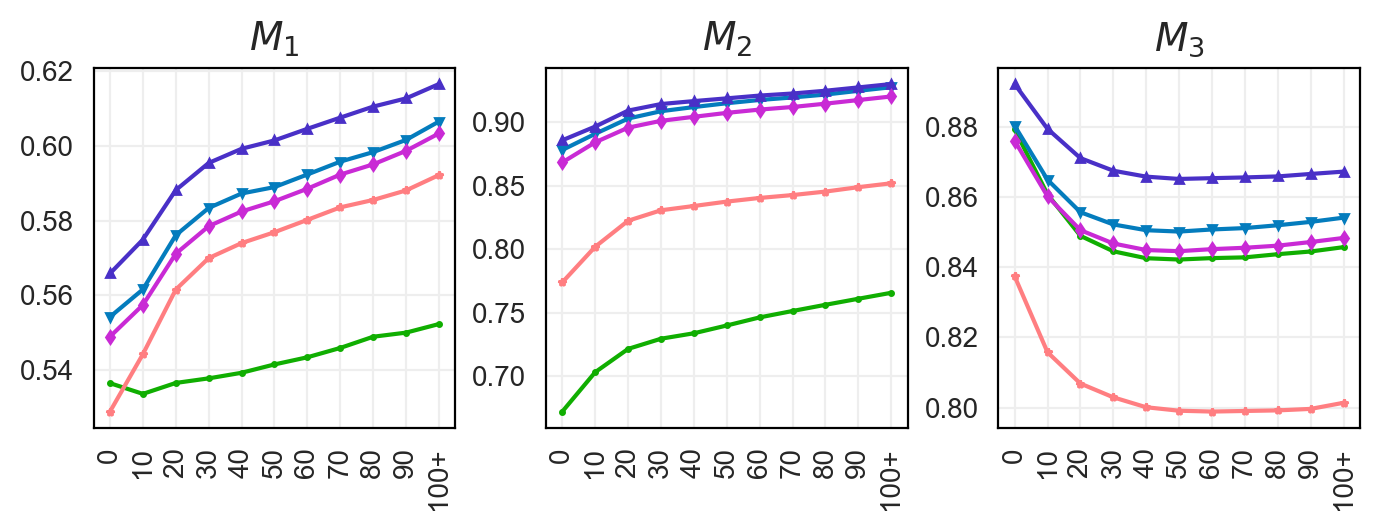

In [155]:
def plot_sensitivity_avg_metric(metrics=('M1', 'M2', 'M3'), datasets=datasets, algos=algos,
                                size=(7, 2.75), dpi=120, cum=True):
    ncol = len(metrics)
    _, axes = plt.subplots(1, ncol, dpi=dpi, figsize=size)
    for i, (ax, metric) in enumerate(zip(axes.flatten(), metrics)):
        ax = U.plot(ax, framebordercolor='k', gridcolor='#eee')
        for alg in algos:
            root = '{}/sensitivity/avg_pings_cumulative/{}/{}.parquet'
            y = pd.concat([
                pd.read_parquet(root.format(ds.data, alg, metric))
                .set_index('binx')['yval'].rename(ds.key) for ds in datasets
            ], axis=1).mean(axis=1).sort_index()
            y.index = y.index.astype(int)
            y.plot(ax=ax, color=alg.color, marker=alg.marker, markersize=3)
        xticks = [str(x) for x in y.index[:-1]] + [f'{y.index[-1]}+']
        ax.set_xticks(y.index, xticks, rotation=90)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_title(r'$%s_%s$' % (metric[0], metric[1]))
        formatter = mpl.ticker.StrMethodFormatter('{x:,.2f}')
        ax.yaxis.set_major_formatter(formatter)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25)

plot_sensitivity_avg_metric(dpi=200)

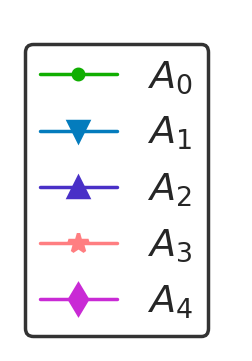

In [34]:
ax = U.plot(size=(1, 1), dpi=250)
handles = [mpl.lines.Line2D([0], [0], lw=1, color=alg.color, marker=alg.marker, 
                            label=alg.math()) for alg in algos]
ax.legend(handles=handles, edgecolor='k')
ax.axis('off');

# Impact to downstream tasks

## Hurricane analysis

In [35]:
ds1, ds3 = datasets[0], datasets[2]

### Distance between pre and post hurricane homes

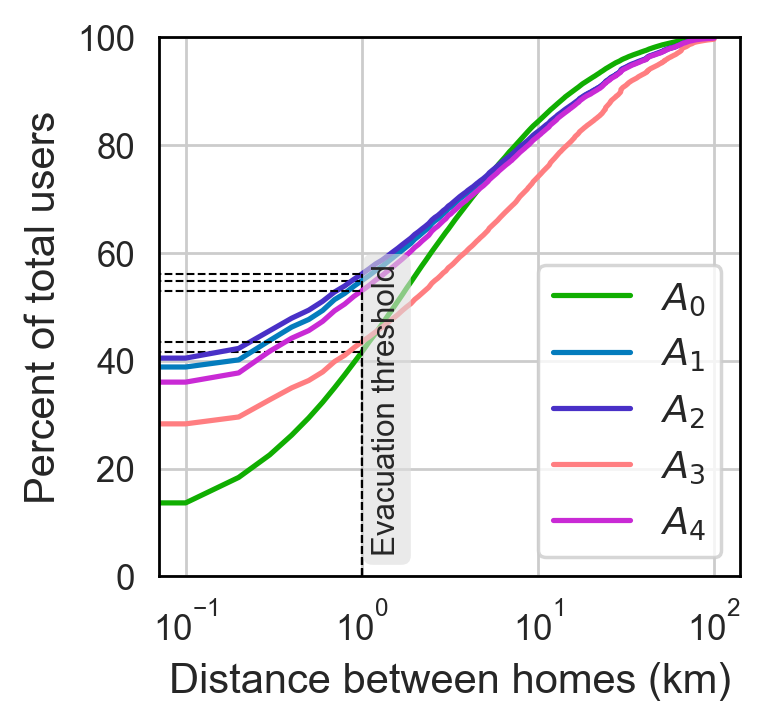

In [36]:
def plot_distance_distr(ds1, ds2, algos=algos, dist_thresh=1e3, max_dist=100e3,
                        size=(3, 2.8), dpi=120, bins=1000):
    ax = U.plot(size=size, dpi=dpi, framebordercolor='k', xlog=1, ylim=(0, 100), 
                xlab='Distance between homes (km)', ylab='Percent of total users')
    for alg in algos:
        h1 = pd.read_parquet(ds1.data / f'homes/{alg}.parquet')
        h2 = pd.read_parquet(ds2.data / f'homes/{alg}.parquet')
        df = h1.merge(h2, on=UID)
        src = list(zip(df['lat_x'], df['lon_x']))
        trg = list(zip(df['lat_y'], df['lon_y']))
        df['dist'] = (hs.haversine_vector(src, trg, unit='m')
                      .clip(0, max_dist) / 1000)
        y, x = np.histogram(df['dist'], bins=bins, density=True)
        x = x[:-1]
        y = y.cumsum() / y.sum() * 100
        ax.plot(x, y, color=alg.color, label=alg.math())
        i = np.argmin(np.abs(x - dist_thresh / 1e3))
        ax.plot([x.min(), x[i]], [y[i]] * 2, ls='--', color='k', lw=0.6)
        ax.axvline(x[i], 0, y[i] / 100, ls='--', color='k', lw=0.6)
    ax.text(x[i] * 1.15, 5, 'Evacuation threshold', rotation=90, fontsize=9,
            bbox=dict(boxstyle='Round', pad=0.3, edgecolor='none', facecolor='#ddd', alpha=0.6))
    ax.legend(loc='lower right')

plot_distance_distr(ds1, ds3, dpi=250)

### Misaligned home zones

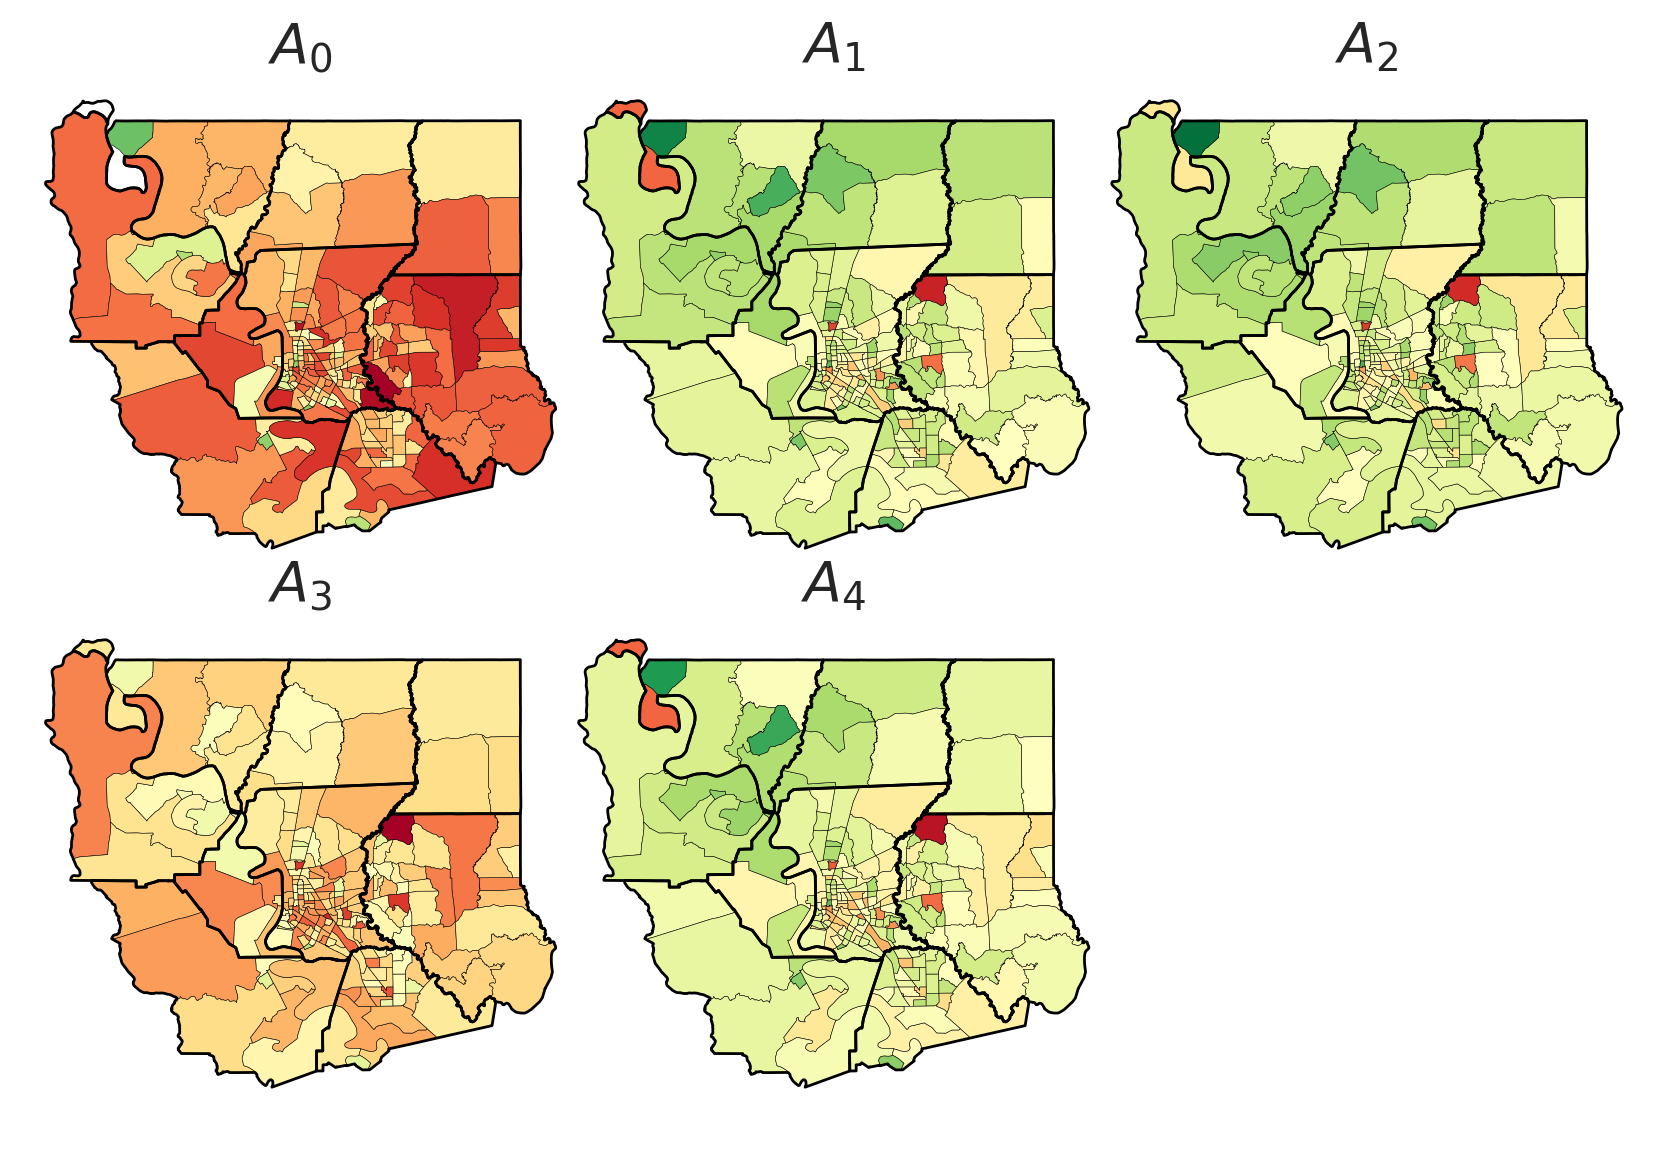

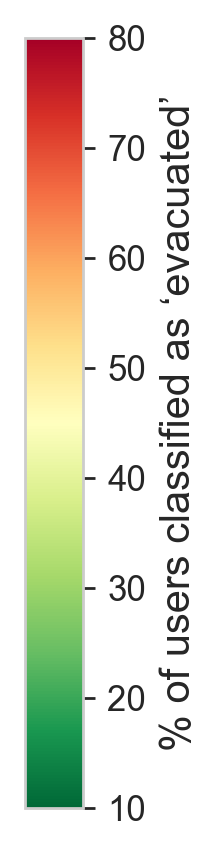

In [37]:
def plot_zonal_mismatch(ds_pre=ds1, ds_post=ds3, scale='tract', dist_thresh=1000, 
                        algos=algos, cmap='RdYlGn_r',
                        min_pct=10, max_pct=80, size=(10.5, 7), dpi=120):
    assert scale in ['cbg', 'tract', 'county']
    assert ds_pre.region == ds_post.region
    cnty = gpd.read_file(ds_pre.region.data / 'counties.gpkg').to_crs(CRS_M)
    zones = (gpd.read_file(ds_pre.region.data / 'cbgs.gpkg')
             .to_crs(CRS_M)[['geoid', 'geometry']])
    if scale == 'tract':
        zones = Gdf(zones.assign(geoid=zones['geoid'].str.slice(0, -1))
                    .groupby('geoid').agg({'geometry': lambda x: x.unary_union})
                    .reset_index()).set_crs(CRS_M)
    elif scale == 'county':
        zones = cnty
    _, axes = plt.subplots(2, 3, figsize=size, dpi=dpi)
    axes = axes.flatten()
    axes[-1].axis('off')
    for i, alg in enumerate(algos):
        ax = U.plot(axes[i], axoff=1)
        ax.set_title(r'%s' % alg.math(), fontsize=20)
        h1 = pd.read_parquet(ds1.data / f'homes/{alg}.parquet')
        h2 = pd.read_parquet(ds2.data / f'homes/{alg}.parquet')
        df = h1.merge(h2, on=UID)
        df = mk.geo.pdf2gdf(df, 'lon_x', 'lat_x', CRS_DEG).to_crs(CRS_M)
        df = df.sjoin(zones, predicate='within')
        src = list(zip(df['lat_x'], df['lon_x']))
        trg = list(zip(df['lat_y'], df['lon_y']))
        df['dist'] = hs.haversine_vector(src, trg, unit='m')
        df['far'] = df['dist'] >= dist_thresh
        df = df.groupby(['geoid', 'far']).size().rename('n_users').reset_index()
        df = df.pivot(index='geoid', columns='far', values='n_users')
        df['pct_far'] = df[True] / (df[True] + df[False]) * 100
        df = zones.merge(df, on='geoid')
        df.plot(ax=ax, column='pct_far', edgecolor='k', linewidth=0.2,
                vmin=min_pct, vmax=max_pct, cmap=cmap)
        cnty.plot(ax=ax, edgecolor='k', lw=1, facecolor='none')
    plt.subplots_adjust(wspace=-0.05, hspace=0)
    ax = U.plot(size=(0.3, 4), dpi=250)
    norm = mpl.colors.Normalize(vmin=min_pct, vmax=max_pct)
    label = '% of users classified as ‘evacuated’'
    mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, label=label)

plot_zonal_mismatch(dpi=200)

## COVID-19 results comparison

In [38]:
ds4, ds5 = datasets[3], datasets[4]

In [39]:
def plot_covid19_fig(ds_base=ds4, ds_alt=ds5, scale='CBG', 
                     size=(5, 2.5), dpi=120):
    assert ds_base.region == ds_alt.region
    assert scale.lower() in ['cbg', 'tract', 'county']
    zones = (gpd.read_file(ds_base.region.data / 'cbgs.gpkg')
             .assign(geoid=lambda df: df['geoid'].str.slice(*{
                 'cbg': (0, None), 'tract': (0, -1), 'county': (0, 5)
             }[scale.lower()]))
             .groupby('geoid').agg({'geometry': lambda x: x.unary_union})
             .reset_index())
    zones = Gdf(zones).set_crs(CRS_DEG)
    x, y = [], []
    for alg in tqdm(algos):
        df = pd.merge(*[pd.read_parquet(ds.data / f'homes/{alg}.parquet')
                        for ds in [ds_base, ds_alt]], on=UID).set_index(UID)
        h1 = mk.geo.pdf2gdf(df, 'lon_x', 'lat_x', crs=CRS_DEG)[['geometry']]
        h2 = mk.geo.pdf2gdf(df, 'lon_y', 'lat_y', crs=CRS_DEG)[['geometry']]
        h1 = h1.sjoin(zones, predicate='within')['geoid'].reset_index()
        h2 = h2.sjoin(zones, predicate='within')['geoid'].reset_index()
        df = pd.merge(h1, h2, on=UID)
        y += [(df['geoid_x'] == df['geoid_y']).sum() / len(df) * 100]
        x += [alg.math()]
    ax = U.plot(size=size, dpi=dpi, framebordercolor='k',
                ylab=f'% users with home\nlocation in same {scale}')
    ax.bar(x, y, color=[alg.color for alg in algos])

# %time x = plot_covid19_fig(dpi=250); x # t=0"07

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 6.65 s, sys: 270 ms, total: 6.92 s
Wall time: 6.61 s


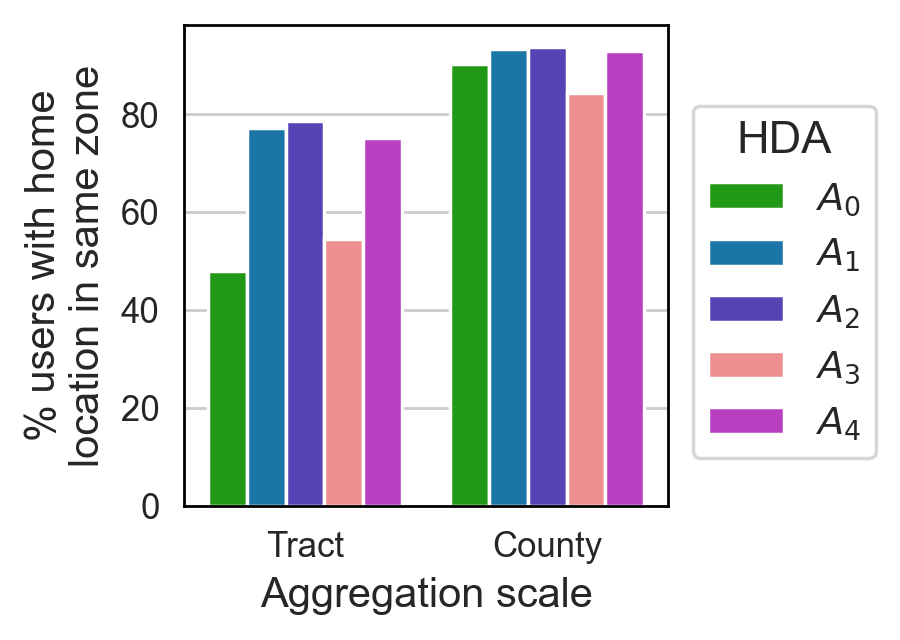

In [159]:
def plot_covid19_fig_all_scales(ds_base=ds4, ds_alt=ds5, size=(2.5, 2.5), dpi=120):
    assert ds_base.region == ds_alt.region
    bg = gpd.read_file(ds_base.region.data / 'cbgs.gpkg').to_crs(CRS_DEG)

    def get_same_prop(df):
        return (df['geoid_x'] == df['geoid_y']).sum() / len(df) * 100
    res = []
    for alg in tqdm(algos):
        df = pd.merge(*[pd.read_parquet(ds.data / f'homes/{alg}.parquet')
                        for ds in [ds_base, ds_alt]], on=UID).set_index(UID)
        h1 = mk.geo.pdf2gdf(df, 'lon_x', 'lat_x', crs=CRS_DEG)[['geometry']]
        h2 = mk.geo.pdf2gdf(df, 'lon_y', 'lat_y', crs=CRS_DEG)[['geometry']]
        h1 = h1.sjoin(bg, predicate='within')['geoid'].reset_index()
        h2 = h2.sjoin(bg, predicate='within')['geoid'].reset_index()
        df = pd.merge(h1, h2, on=UID)
        res.append(dict(scale='Block group', alg=alg.math(), pct_same=get_same_prop(df)))
        for scale, idx in [('Tract', (0, -1)), ('County', (0, 5))]:
            df2 = df.assign(geoid_x=df['geoid_x'].str.slice(*idx),
                            geoid_y=df['geoid_y'].str.slice(*idx))
            y = get_same_prop(df2)
            res.append(dict(scale=scale, alg=alg.math(), pct_same=y))
    res = Pdf(res).rename(columns={'alg': 'HDA'})
    res = res.query('scale != "Block group"')
    ax = U.plot(size=size, dpi=dpi, framebordercolor='k')
    sns.barplot(ax=ax, data=res, x='scale', y='pct_same', hue='HDA',
                palette=sns.color_palette([alg.color for alg in algos]))
    sns.move_legend(ax, loc=(1.05, 0.1))
    ax = U.plot(ax, xlab='Aggregation scale',
                ylab='% users with home\nlocation in same zone')
    # return res

%time x = plot_covid19_fig_all_scales(dpi=250); x

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 8.18 s, sys: 302 ms, total: 8.49 s
Wall time: 8.16 s


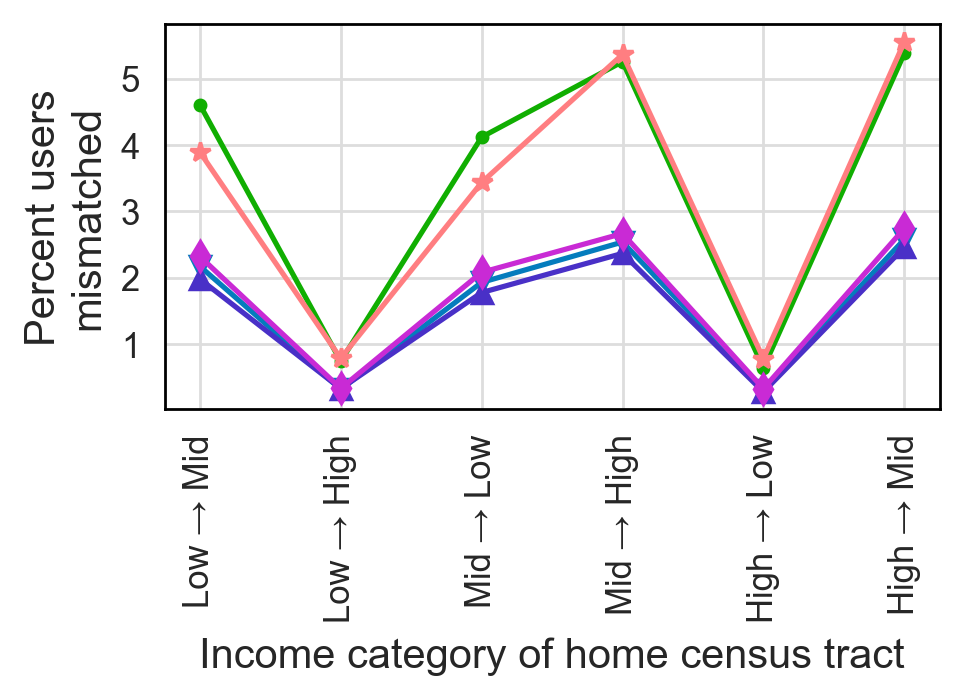

In [224]:
def plot_covid19_fig_all_scales_pairwise(ds_base=ds4, ds_alt=ds5,
                                         income_lims=(1667 * 12, 3350 * 12),
                                         size=(4, 2), dpi=120):
    assert ds_base.region == ds_alt.region
    acs = gpd.read_file(ds_base.region.data / 'acs.gpkg').to_crs(CRS_DEG)
    acs['geoid'] = acs['geoid'].str.slice(0, -1)
    acs = Gdf(acs.groupby('geoid').agg({
        'inc_avg': np.mean, 'geometry': lambda x: x.unary_union})
              .reset_index()).set_crs(CRS_DEG)
    inc_bins = [0] + list(income_lims) + [np.inf]
    inc_bin_labels = ['Low', 'Mid', 'High']
    acs['inc'] = pd.cut(acs['inc_avg'], inc_bins, labels=inc_bin_labels)
    acs = Gdf(acs.groupby('inc').agg({'geometry': lambda x: x.unary_union})
              .reset_index()).set_crs(CRS_DEG)
    ax = U.plot(size=size, dpi=dpi, framebordercolor='k', gridcolor='#ddd',
                ylab='Percent users\nmismatched',
                xlab='Income category of home census tract')
    res = []
    for alg in tqdm(algos):
        df = pd.merge(*[pd.read_parquet(ds.data / f'homes/{alg}.parquet')
                        for ds in [ds_base, ds_alt]], on=UID).set_index(UID)
        h1 = mk.geo.pdf2gdf(df, 'lon_x', 'lat_x', crs=CRS_DEG)[['geometry']]
        h2 = mk.geo.pdf2gdf(df, 'lon_y', 'lat_y', crs=CRS_DEG)[['geometry']]
        h1 = h1.sjoin(acs, predicate='within')
        h2 = h2.sjoin(acs, predicate='within')
        df = pd.merge(h1, h2, on=UID)
        pct = (df.groupby(['inc_x', 'inc_y']).size().rename('n_users')
               .reset_index().query('inc_x != inc_y')
               .astype({'inc_x': str, 'inc_y': str}))
        pct['inc'] = pct['inc_x'] + ' → ' + pct['inc_y']
        pct['pct'] = pct['n_users'] / len(df) * 100
        ax.plot(pct['inc'], pct['pct'], color=alg.color, marker=alg.marker)
    ax.set_xticks(pct['inc'], pct['inc'], rotation=90)
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))

%time x = plot_covid19_fig_all_scales_pairwise(dpi=250); x # t=0:09